In [1]:
import os
import glob
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Understanding the problem

NBA draft is an annual event in which teams from the National Basketball Association can each select two players (over the draft's two rounds) that are eligible and willing to join the league. NBA franchises usually aim to select either the best player available or the one that best suits their current roster needs. The order of selection, simply put, is determined by the teams' recent performance, with the weakest teams selecting first. Players enrolled for the draft can be divided into four groups: lottery (those selected with picks 1-14), first round outside the lottery (picks 15-30), second round (31-60), and undrafted. The majority of players entering the draft have at least one year of recent college experience (playing in the NCAA). The aim of this project is to predict a given player's draft position (i.e. one of the four groups defined before) based on the college stats alone. Various machine learning techniques will be employed to solve that problem. The dataset that will be used to train the models on, contains information about the players' last seasons in the NCAA Division I from years 2010-2020 and was scraped off the sports-reference portal (the source code can be found in the get_data.ipynb). See the README.md file for more information.

Predicting players' draft position only using their latest college stats constitutes a challange that may be difficult, not to say impossible, to overcome: this approach not only neglects a lot of intangible assets the players may or may not have that are not reflected in simplified numerical metrics, but it also ignores the outside factors that play a crucial role in the decision-making process of the NBA franchises' general managers when they are making their selections (e.g. current and future roster needs, strength of the draft class, etc.). An attempt to tackle these shortcoming will be made, however, although the objective is to build a model that will separate all four draft groups from each other the most effectively, it is very likely, and should be expected, that even the best model will still make a significant number of mislabelings. Nevertheless, a tool that is able to determine what draft group a given player should belong to provided their college stats (all other factors discarded) could still be very useful for the decision-makers.

# Step 0: Merge and clean the data

Before any real work on the data scraped off the sports-reference.com website can commence, it is first necessary to concatenate all the csv files the players data is stored in (note it was downloaded in batches of 50 records at a time), merge it with the csv file containing school data, perform some basic cleaning operations on the resultant dataset, and save it so that it can be later used in the actual analysis.

Let's first specify paths to relevant files and define a function that will read, concatenate, and merge the data.

In [3]:
PATH_READ_SCHOOLS = 'raw data/schools_data.csv'
PATH_READ_PLAYERS = 'raw data/players data/*.csv'
PATH_SAVE = 'clean data/ncaa_players.csv'

In [4]:
def merge_data(path_schools=PATH_READ_SCHOOLS, path_players=PATH_READ_PLAYERS):
    players_df = pd.DataFrame()
    for filepath in glob.iglob(path_players):
        players_df = pd.concat([players_df, pd.read_csv(filepath, index_col=0)])
    players_df = players_df[players_df['season']!=2022]
    schools_df = pd.read_csv(path_schools, index_col=0)
    full_df = pd.merge(players_df, schools_df, how='left', on=['season', 'school_url'])
    return full_df

In [5]:
df = merge_data()

With all the data stored in a dataframe, it is now possible to perform some basic cleaning operations. Below, columns of the dataframe are rearranged and renamed.

In [6]:
new_col_order = ['name', 'school_name', 'season', 'school_year', 'position', 'height', 'weight', 'games_played_x',
                 'games_started', 'games_won', 'mpg', 'fg_pct', 'fg3_pct', 'fg3a', 'ft_pct', 'fta', 'off_rpg', 'def_rpg', 'apg',
                 'spg', 'bpg', 'tpg', 'fpg', 'ppg', 'per', 'ts_pct', 'eff_fg_pct_x', 'fg3a_rate', 'off_reb_pct', 'def_reb_pct',
                 'ast_pct', 'usg_pct', 'win_shares_40_min', 'plus_minus', 'max_points', 'max_assists', 'max_steals',
                 'max_blocks', 'max_rebounds', 'std_points', 'std_assists', 'std_steals', 'std_blocks', 'std_rebounds',
                 'games_played_y', 'win_pct', 'ncaa_tournament', 'pace', 'eff_fg_pct_y', 'srs_off', 'srs_def', 'sos',
                 'team_ppg', 'opp_ppg', 'off_rating', 'def_rating', 'rank', 'draft']
new_col_names = ['name', 'school', 'season', 'school_year', 'position', 'height', 'weight', 'games_played',
                 'games_started', 'games_won', 'mpg', 'fg_pct', 'fg3_pct', 'fg3a', 'ft_pct', 'fta', 'off_rpg', 'def_rpg', 'apg',
                 'spg', 'bpg', 'tpg', 'fpg', 'ppg', 'per', 'ts_pct', 'eff_fg_pct', 'fg3a_rate', 'off_reb_pct', 'def_reb_pct',
                 'ast_pct', 'usg_pct', 'win_shares_per_40_mins', 'plus_minus', 'max_points', 'max_assists', 'max_steals',
                 'max_blocks', 'max_rebounds', 'std_points', 'std_assists', 'std_steals', 'std_blocks', 'std_rebounds',
                 'team_games_played', 'win_pct', 'ncaa_tournament', 'pace', 'team_eff_fg_pct', 'srs_off', 'srs_def', 'sos',
                 'team_ppg', 'opp_ppg', 'off_rating', 'def_rating', 'ap_poll_rank', 'draft']

df = df[new_col_order].rename(columns={old_name: new_name for old_name, new_name in zip(new_col_order, new_col_names)})

Duplicates and records with missing values in categorical variables will be dropped from the dataset, and so will be players that have not played a single game or averaged less than a minute a game.

In [7]:
df.drop_duplicates(inplace=True)
df.dropna(subset=['school', 'school_year', 'position'], inplace=True)
df = df[(df['games_played'] > 0) & (df['mpg'] >= 1)]
df.index = list(range(len(df)))

Because the data concerns players from the American collegiate league, players' heights and weights are expressed in imperial units. Just for convenience, let's define and apply functions that convert these quantities to metric units.

In [8]:
def convert_height(height_imperial):
    CM_LIST = [30.48, 2.54]
    try:
        height_split = height_imperial.split('-')
        return round(sum([a*int(b) for a, b in zip(CM_LIST, height_split)]))
    except AttributeError:
        return height_imperial

def convert_weight(weight_imperial):
    KG_IN_LB = 0.45359237
    try:
        return round(weight_imperial * KG_IN_LB)
    except ValueError:
        return weight_imperial

In [9]:
df['height'] = df['height'].apply(convert_height)
df['weight'] = df['weight'].apply(convert_weight)

When the data was collected, the information about a specific pick a given player was selected with was preserved. However, what is really relevant for this project is not the exact pick, but the group they were drafted in instead. A function encoding the exact draft selections as an ordinal variable (1 = lottery, 2 = first round, 3 = second round, 4 = undrafted) is defined and applied to the target variable below. Original draft picks from the 2021 NBA draft are preserved in a seperate dataframe for future reference.

In [10]:
def draft_ordinal(draft):
    try:
        draft = int(draft)
        if draft <= 14:
            draft = 1
        elif draft <= 30:
            draft = 2
        elif draft <= 60:
            draft = 3
    except ValueError:
        draft = 4
    return draft

In [11]:
draft_2021 = df[df['season']==2021].loc[:, ['name', 'draft']]
df['draft'] = df['draft'].apply(draft_ordinal)

 Resultant set is exported to a csv file in a location specified earlier.

In [12]:
df.to_csv(PATH_SAVE)

# Step 1: Load and inspect the data

Let's now define the path to the data file, write a function to load it, and execute it.

In [14]:
READ_PATH = 'clean data/'
DATA_FILE = 'ncaa_players.csv'

In [15]:
def load_players_data(file_path=READ_PATH, file_name=DATA_FILE, index_col=0):
    csv_path = os.path.join(file_path, file_name)
    return pd.read_csv(csv_path, index_col=index_col)

In [16]:
dataset = load_players_data()

Let's have a quick glimpse at the data.

In [17]:
dataset.head()

,name,school,season,school_year,position,height,weight,games_played,games_started,games_won,...,team_eff_fg_pct,srs_off,srs_def,sos,team_ppg,opp_ppg,off_rating,def_rating,ap_poll_rank,draft
0,Michael Lyons,Air Force,2013,senior,G,196.0,88.0,30,30,17,...,0.551,4.05,0.01,4.16,70.0,67.8,110.09,102.85,NaN,4
1,Tom Fow,Air Force,2011,senior,F,198.0,93.0,32,32,16,...,0.540,-1.94,4.65,3.31,64.8,65.1,106.44,101.45,NaN,4
2,Derek Brooks,Air Force,2011,senior,F,196.0,91.0,32,1,16,...,0.540,-1.94,4.65,3.31,64.8,65.1,106.44,101.45,NaN,4
3,Evan Washington,Air Force,2011,senior,G,193.0,91.0,32,32,16,...,0.540,-1.94,4.65,3.31,64.8,65.1,106.44,101.45,NaN,4
4,Taylor Broekhuis,Air Force,2013,senior,C,201.0,88.0,32,32,18,...,0.551,4.05,0.01,4.16,70.0,67.8,110.09,102.85,NaN,4


In [18]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18386 entries, 0 to 18385
Data columns (total 58 columns):
name                      18386 non-null object
school                    18386 non-null object
season                    18386 non-null int64
school_year               18386 non-null object
position                  18386 non-null object
height                    18355 non-null float64
weight                    18359 non-null float64
games_played              18386 non-null int64
games_started             18386 non-null int64
games_won                 18386 non-null int64
mpg                       18386 non-null float64
fg_pct                    17777 non-null float64
fg3_pct                   14647 non-null float64
fg3a                      18386 non-null float64
ft_pct                    15914 non-null float64
fta                       18386 non-null float64
off_rpg                   18386 non-null float64
def_rpg                   18386 non-null float64
apg                  

As it can be seen above, there are 18386 unique records in the dataset with 57 features and 1 target variable each. The vast majority of values is non-null, however, as many as 16 columns are missing some values (although, for the most part, not many). Some of the incomplete data are actually holding valuable information: for example, null values in the three point field goal percentage (fg3_pct) column most likely represent players that have not attempted a single three point shot (fg3a). As it turns out, the cell below confirms that it is true. Other columns may have gaps because they are derived from other columns that are missing values (e.g. true shooting percentage relies on field goal attempts and free throw attempts). In some cases, however, incomplete data indicates nothing more than imperfect data availability (as it is the case with height and weight).

The ap_poll_rank column, representing a given player's team's rank in the Associated Press poll at the end of the season, has only 1156 (6.3%) non-null values. This, however, is a special case, as only 25 teams are ranked in each edition of the AP poll. It is therefore only reasonable that the vast majority of schools do not have a rank and are missing data in that column. 

As demonstrated, there may be various reasons for gaps in the dataset, and each of them will have to be treated individually when dealing with missing values. Columns that are missing data as a result of imperfect data availability will be filled with a median value, those representing a performance metric that is not present in all the players (e.g. fg3_pct) will be filled with zeros. The ap_poll_rank variable will be encoded with ones for teams that made the ranking and zeros for those that did not.

In [19]:
all(dataset[dataset['fg3_pct'].isna()]['fg3a'] == 0)

True

Let's now look at the distributions of numerical variables.

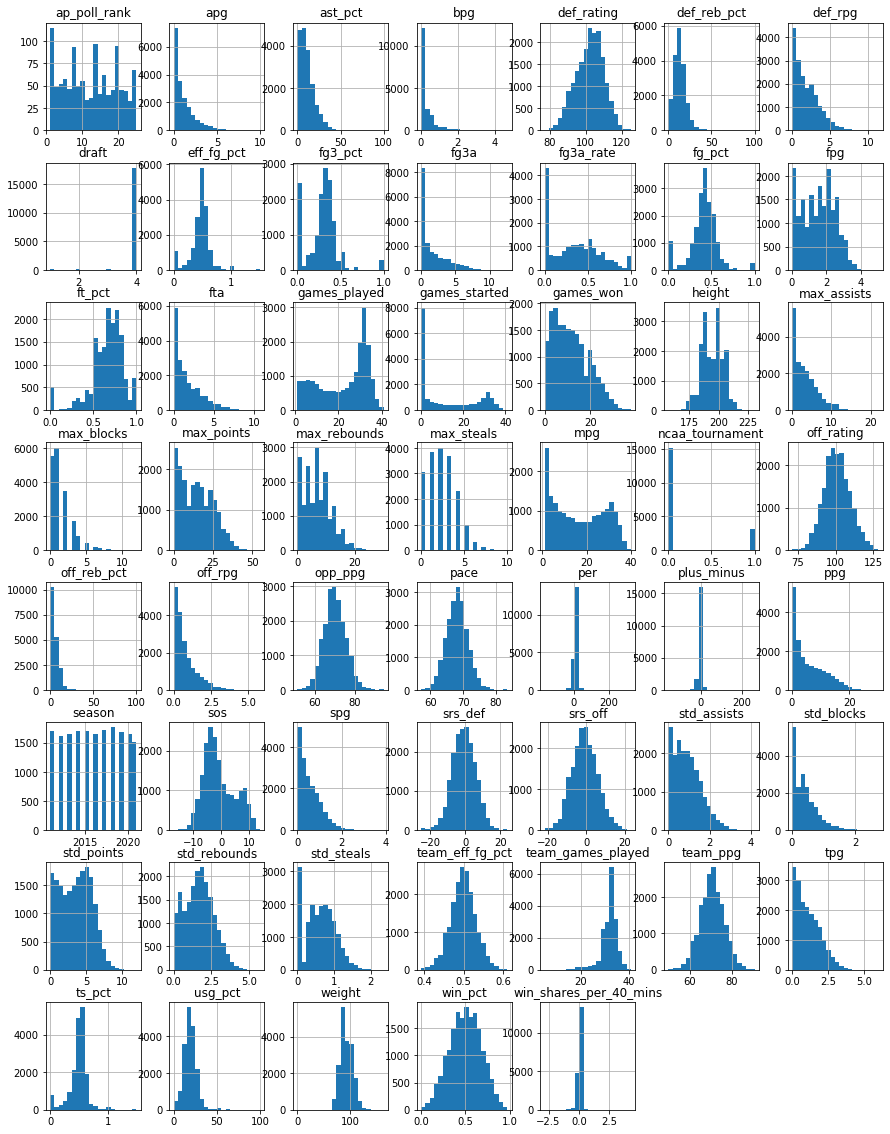

In [20]:
dataset.hist(bins=20,figsize=(15,20))
plt.show()

Looking at the graphs, two things stand out. First of all, there seems to be a small number of players whose effective field goal percentage (eff_fg_pct) is higher than 1 (all the metrics corresponding to a percentage in this dataset are expressed as a decimal fraction). In fact, as it can be seen in the cell below, there are 82 such players in the set. Although it seems to be an obvious mistake, it is not: with how this metric is calculated, it is actually possible to achieve a value above 100% (despite how counterintuitive, not to say ridiculous, this might seem).

In [21]:
len(dataset[dataset['eff_fg_pct']>1])

82

More importantly though, it cannot go unnoticed how imbalanced the target variable (draft) is: over 97% of all records in the dataset belong to the 'undrafted' class, as it is demostrated below. It is not particularly surprising, as one can expect only a small proportion of college players to ever get drafted by an NBA team, however, later in the process it will be necessary to deal with the overrepresentation of this particular target category to prevent models from always predicting the most prevalent class. 

In [22]:
dataset['draft'].value_counts()/len(dataset['draft'])

4    0.971119
3    0.013815
2    0.007778
1    0.007288
Name: draft, dtype: float64

It is now time to split the dataset into X (columns with predictor variables) and y (the target variable), and subsequently divide it into training, validation, and test sets. With how imbalanced the dataset is, it is important to ensure that the proportions of target classes are roughly the same in each of the three sets, and for that reason a stratified sampling strategy was employed and implemented in the function defined below. The reasoning behind the decision to set aside the validation set (instead of just using cross-valiation on the training set) will be explained later. To ensure consistent results when re-running the code, a constant random seed (that will be used throughout the project whenever any stochasticity is involved) is also set here.

In [23]:
X = dataset.iloc[:, :-1]
y = dataset.iloc[:, -1]

In [24]:
RS = 101

In [25]:
from sklearn.model_selection import train_test_split

def stratified_three_fold_split(X, y, stratify, test_size=0.3, valid_size=0.2, random_state=None):
    X_train_valid, X_test, y_train_valid, y_test = train_test_split(X,
                                                                    y,
                                                                    test_size=test_size,
                                                                    stratify=stratify,
                                                                    random_state=random_state)
    X_train, X_valid, y_train, y_valid = train_test_split(X_train_valid,
                                                          y_train_valid,
                                                          test_size=valid_size,
                                                          stratify=y_train_valid,
                                                          random_state=random_state)
    return X_train, X_valid, X_test, y_train, y_valid, y_test  

In [26]:
X_train, X_valid, X_test, y_train, y_valid, y_test = stratified_three_fold_split(X=X, y=y, stratify=y, random_state=RS)

# Step 2: Data exploration

With the test set now set aside, let's have a closer look at the training data to gain some insight on how to best approach the problem. First, correlations between features will be examined. Below is the heatmap of the Pearson's coefficient of correlation of every pair of numerical variables found in the training set.

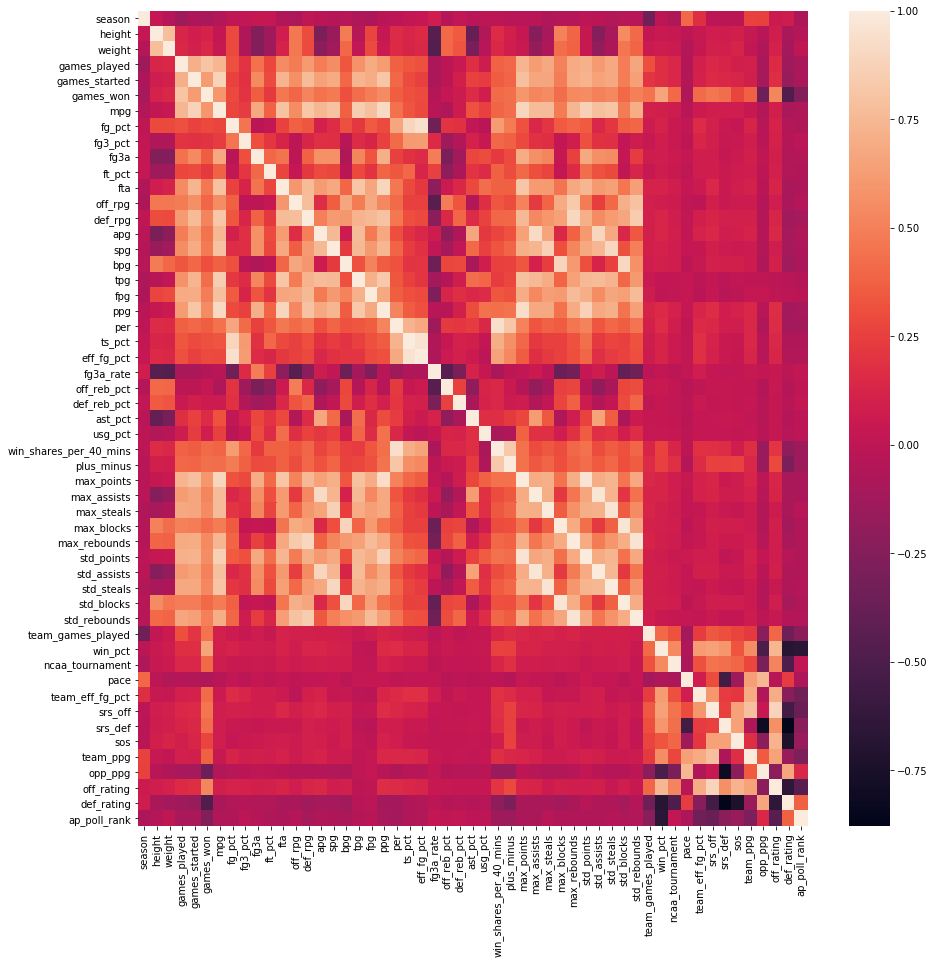

In [27]:
corr_matrix = X_train.corr()
fig = plt.figure(figsize=(15,15))
sns.heatmap(corr_matrix)
plt.show()

Looking at the above correlation matrix it is easy to spot that some features are strongly correlated with some of the other variables. There seems to be five areas on the heatmap where the correlations are the strongest. To be able to better identify them, let's plot a binary heatmap highlighting areas where the absolute correlation coefficient is larger than or equal to 0.6.

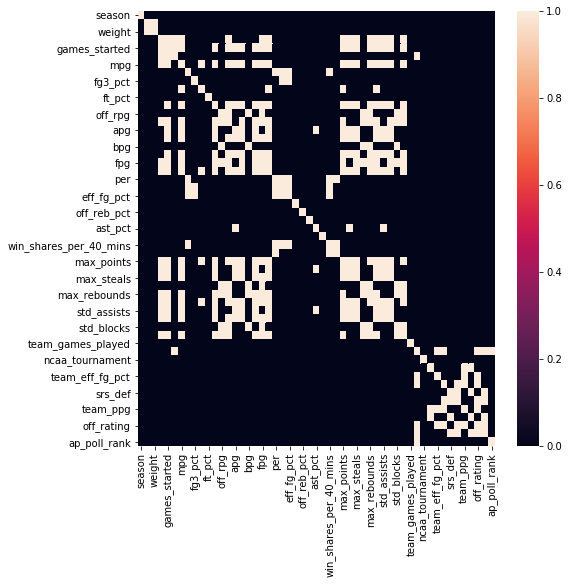

In [28]:
fig = plt.figure(figsize=(8, 8))
sns.heatmap(abs(corr_matrix) >= 0.6)
plt.show()

It seems like the majority of basic player stats (upper left corner) are correlated to some extent, many relationships can be found in the team stats section (bottom right corner), and strong correlations can also be spotted in the area of maximum season achievements and standard deviations of the corresponding metrics (e.g. max_points, max_rebounds, std_points, std_rebounds, etc.) both with each other, and with basic player stats. Some of these relationship are not very surprising and come from the properties of the variables themselves: it is only natural that true shooting percentage correlates with field goal and three point field goal percentage (as the former one is calculated based on the latter two), and that the standard deviation of particular season metrics is positively correlated with the maximum values of these metrics (as high maximum values are likely to deviate from the average and increase the standard deviation).

Moving forward, it might be worth considering to limit these correlations between the variables in an effort to reduce the dimensionality of the dataset without losing any useful information. If it is decided that dimensionality reduction will not be detrimental to the overall model performance and might significantly increase training time, some of the features with the strongest correlations with others will be dropped from the dataset. In such a scenario, standard deviations would be discarded, field goal percentage and effective field goal percentage would also be dropped as both these metrics are strongly correlated with true shooting percentage. Offensive and defensive simple rating systems would be excluded from the dataset as they are correlated with the strenght of schedule (sos), team points per game (team_ppg), and opponent points per game (opp_ppg).

New features might also be engineered to normalize some of the player stats with regards to the minutes per game and the number of games they played. Player games played (games_played) will be expressed as a fraction of the total team games (team_games_played). Player games started (games_started) and player games won (games_won) will be expressed as a fraction of player games played. All basic player stats that are expressed as per game averages, will be transformed to reflect the same metrics per minute played. Season highs (e.g. max_points) will be expressed as a multiple of per minute average. 

Now, let's try to figure out if there is something obvious that differentiates drafted and undrafted players. Principal Component Analysis will be applied to the numerical features of the dataset and first two components that explain the most variance in data will be plotted against each other so that it is possible to visually examine whether drafted players stand out from the rest.

In [29]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_numerical = X_train[X_train.select_dtypes(include=np.number).columns.tolist()]
X_numerical = X_numerical.fillna(0)
X_numerical = X_numerical.drop('season', axis=1)
pca.fit(X_numerical)
print(pca.explained_variance_ratio_)
X_pca = pca.transform(X_numerical)
X_pca_df = pd.DataFrame(X_pca)
X_pca_df.index = X_train.index

[0.35466708 0.15474893]


As it can be seen above, first two principal components explain only around 50% of the total variance. This is definitely not enough to assume that the remaining components are irrelevant to the problem, however, possibly it will be enough to provide some useful insight when plotted on a graph.

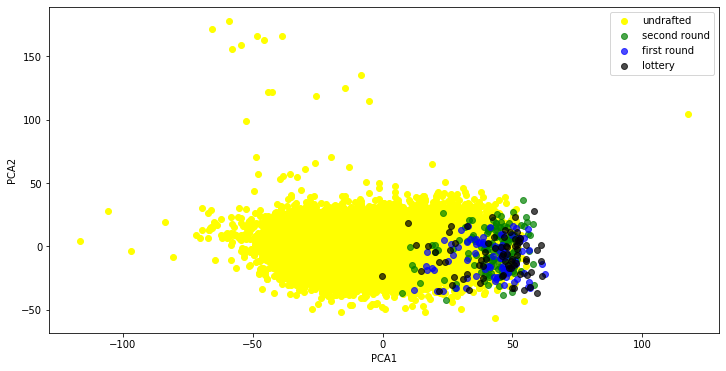

In [30]:
lottery_ind = y_train[y_train==1].index
first_round_ind = y_train[y_train==2].index
second_round_ind = y_train[y_train==3].index
undrafted_ind = y_train[y_train==4].index

pca1_lottery = X_pca_df.loc[lottery_ind, 0]
pca2_lottery = X_pca_df.loc[lottery_ind, 1]
pca1_first_round = X_pca_df.loc[first_round_ind, 0]
pca2_first_round = X_pca_df.loc[first_round_ind, 1]
pca1_second_round = X_pca_df.loc[second_round_ind, 0]
pca2_second_round = X_pca_df.loc[second_round_ind, 1]
pca1_undrafted = X_pca_df.loc[undrafted_ind, 0]
pca2_undrafted = X_pca_df.loc[undrafted_ind, 1]

plt.figure(figsize=(12,6))
ax = plt.axes()
ax.scatter(pca1_undrafted, pca2_undrafted, c='yellow')
ax.scatter(pca1_second_round, pca2_second_round, c='green', alpha=0.7)
ax.scatter(pca1_first_round, pca2_first_round, c='blue', alpha=0.7)
ax.scatter(pca1_lottery, pca2_lottery, c='black', alpha=0.7)
ax.legend(['undrafted', 'second round', 'first round', 'lottery'])
ax.set_xlabel('PCA1')
ax.set_ylabel('PCA2')
plt.show()

What stands out in the above graph is that altough the groups are nowhere near being lineary seperable, drafted players definitely have a lot in common. It seems like the majority of data points representing drafted players can be found in the bottom right corner of the plot: some of them, those far right, are clear of all undrafted data points. Even though the graph clearly indicates that high values of the first component and low values of the second component tend to correspond to a higher chance of getting drafted, this relationship is not strong enough to seperate both groups of players (let alone distinguishing between particular groups of drafted players): a lot of undrafted data points are also located in the bottom right corner of the chart. 

However, it has to be kept in mind that only two components (that explain only about 50% of all the variance in data) are presented in the graph. It is therefore possible that the groups are much easier to seperate if more variables are taken into consideration and the fact that drafted players are all so close together on the above graph is a promising indicator.

Lastly, correlations between the independent variables and the target variable will be examined. In the cell below, features with the Pearson's correlation coefficient with the target variable that is higher (or lower) than 0.2 (or - 0.2) are listed. Note that because of how the target variable is constructed (lower value = better draft position) negative values actually indicate positive relationship between a given variable and the odds of high draft selection.

As it turns out, among the variables that affect the target variable the most are player points per game (ppg), player games won (games_won), player free throw attempts per game (fta), and team offensive rating. It seems like good individual performance of a given player (i.e. scoring a lot of points, recording many assists, etc.) is not enough to get them drafted: their chances increase if their good individual performance contributes to a good team performance. Or, to look at it at a different angle that is perhaps more fitting in a college setting, they are good enough to perform well on a good team. It makes sense, as in the NCAA it is often the case that better teams face better opponents. It might therefore be a reasonable idea to adjust player's individual performance for the average strength of the opponents they faced, expressed with the sos (strength of schedule) variable.

In [31]:
Xy = pd.merge(X_train, y_train, on=X_train.index)
target_corr = Xy.corr()['draft']
print(target_corr[abs(target_corr)>0.2])

games_won         -0.232658
fta               -0.258086
def_rpg           -0.254717
bpg               -0.228182
ppg               -0.277417
max_points        -0.223248
ncaa_tournament   -0.210388
srs_off           -0.236822
sos               -0.237411
off_rating        -0.246125
def_rating         0.233576
ap_poll_rank       0.237204
draft              1.000000
Name: draft, dtype: float64


Information about features that are correlated with the target variable the least may also prove valuable in further steps. As it can be seen below, apart from the season variable (which would be excluded from further analysis anyway), team's pace, player's offensive rebound percentage (off_reb_pct), and three point field goal attempts rate (fg3a_rate) all have negligible correlation with the target variable. When transforming the data it will be decided if these variables should be kept in the dataset. 

In [32]:
print(target_corr[abs(target_corr)<=0.05])

key_0         -0.017276
season        -0.012697
fg3a_rate      0.033955
off_reb_pct   -0.032228
pace          -0.008844
Name: draft, dtype: float64


# Step 3: Transforming features

Thanks to the insight gained through data exploration it is now possible to come up with a strategy on how to transform the dataset. As it was suggested before, it seems reasonable to adjust a given player's individual performance for the average strength of his opponets. Moreover, to engineer metrics that are more comparable between individuals, absolute values such as the number of games played, all "per game" stats, and player's season highs in points, assists, blocks, etc. will be normalized by an appropriate metric (e.g. number of team games played, numer of minutes per game, etc.). Finally, irrelavant features, or those with a very low correlation coefficient with the target variable, will be dropped from the dataset.

In addition to these custom transformations, columns with missing values will be filled, and categorical variables will be one-hot encoded. Moreover, all numerical features will be standarized by removing the mean and scaling to unit variance.

But first, let's group variables in a way that will enable aggregate transformations. For example, when adjusting for the strength of the opponent, it makes sense to multiply favorable variables (e.g. points per game, field goal percentage) by the strength of schedule, while it is reasonable to multiply unfavorable features (e.g. turnovers per game) by one minus the strength of schedule. By defining such groups of features it will be later possible to apply a given transformation to a whole group at once. Because sklearn transformers return numpy arrays, and not pandas dataframes, it is important to find indices of these features for a seamless integration of custom transformers with the rest of the pipeline.

In [33]:
numeric_features = X.select_dtypes(include=np.number).columns
cat_features = X.select_dtypes(include=np.object).columns

negative_stats_names = ['plus_minus', 'sos']
favorable_stats_names = ['fg_pct', 'fg3_pct', 'fta','off_rpg', 'def_rpg', 'apg',
                         'spg', 'bpg', 'ppg', 'per', 'ts_pct', 'eff_fg_pct',
                         'off_reb_pct', 'def_reb_pct', 'ast_pct', 'usg_pct',
                         'win_shares_per_40_mins', 'plus_minus', 'win_pct', 'pace',
                         'team_eff_fg_pct', 'team_ppg', 'off_rating']
unfavorable_stats_names = ['tpg', 'fpg', 'opp_ppg', 'def_rating']
per_game_stats_names = ['fg3a', 'fta', 'off_rpg', 'def_rpg',
                        'apg','spg', 'bpg', 'tpg', 'fpg', 'ppg']
max_stats_names = ['max_points', 'max_assists', 'max_steals', 'max_blocks', 'max_rebounds']
average_stats_names = ['ppg', 'apg', 'spg', 'bpg', 'off_rpg', 'def_rpg']
to_drop_num_names = ['season']#, 'pace'], #'std_points', 'std_assists', 'std_steals', 'std_blocks', 'std_rebounds']
to_drop_cat_names = ['name', 'school']
fill_with_zeros_names = [feat for feat in numeric_features if feat not in ('height', 'weight', 'ap_poll_rank')]
fill_with_median_names = ['height', 'weight']
other_cols_names = ['season', 'games_played', 'games_started', 'mpg', 'plus_minus',
                    'max_points', 'max_assists', 'max_steals', 'max_blocks',
                    'max_rebounds', 'team_games_played', 'sos', 'ap_poll_rank']

negative_stats = np.where(np.isin(numeric_features, negative_stats_names))[0]
favorable_stats = np.where(np.isin(numeric_features, favorable_stats_names))[0]
unfavorable_stats = np.where(np.isin(numeric_features, unfavorable_stats_names))[0]
per_game_stats = np.where(np.isin(numeric_features, per_game_stats_names))[0]
max_stats = np.where(np.isin(numeric_features, max_stats_names))[0]
average_stats = np.where(np.isin(numeric_features, average_stats_names))[0]
fill_with_zeros = np.where(np.isin(numeric_features, fill_with_zeros_names))[0]
fill_with_median = np.where(np.isin(numeric_features, fill_with_median_names))[0]
to_drop_num = np.where(np.isin(numeric_features, to_drop_num_names))[0]
to_drop_cat = np.where(np.isin(cat_features, to_drop_cat_names))[0]
(season, games_played, games_started, mpg, plus_minus,
 max_points, max_assists, max_steals, max_blocks, max_rebounds,
 team_games_played, sos, ap_poll_rank) = np.where(np.isin(numeric_features, other_cols_names))[0]

Let's define the first custom transformer: NegativeScaler will be used to convert variables that can take on negative values to a positive range. It may prove useful later when further transformations are applied to these (and other) features.

In [34]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import MinMaxScaler

class NegativeScaler(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        self.mms = MinMaxScaler((0.001, 0.999))
        self.mms.fit(X[:, negative_stats])
        return self
    
    def transform(self, X, y=None):
        X[:, negative_stats] = self.mms.transform(X[:, negative_stats])
        return X

FeatureAdjuster will be used to adjust some of the player's individual stats for the team's strength of schedule. Favorable and unfavorable stats are multiplied by the strength of schedule or one minus strength of schedule accordingly. The keep_old boolean parameter determines whether these newly engineered features should replace the old ones, or should they be added to the dataset while the old features are kept.

In [35]:
class FeatureAdjuster(BaseEstimator, TransformerMixin):
    def __init__(self, keep_old=False):
        self.keep_old = keep_old
    
    def fit(self, X, y=None):
        self.ns = NegativeScaler()
        self.ns.fit(X)
        return self
    
    def transform(self, X, y=None):
        X = self.ns.transform(X)
        favorable_adj = X[:, favorable_stats] * X[:, sos][:, None]
        unfavorable_adj = X[:, unfavorable_stats] * (1 - X[:, sos])[:, None]
        if not self.keep_old:
            X[:, favorable_stats] = favorable_adj
            X[:, unfavorable_stats] = unfavorable_adj
            return X
        return np.c_[X, favorable_adj, unfavorable_adj]

Similarly, the FeatureNormalizer is defined. The number of games started by a player is divided by the total number of games played. The number of games played, on the other hand, is divided by the total number of team games. 'Per game' stats are divided by minutes per game to express the same metrics on a 'per minute' basis. Player's maximum season achievements (e.g. season high in points) are divided by the respective average (per game) stats. Once again, old variables can be either dropper or kept in the dataset depending on the value of the keep_old parameter.

In [36]:
class FeatureNormalizer(BaseEstimator, TransformerMixin):
    def __init__(self, keep_old=False):
        self.keep_old = keep_old
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        games_started_norm = X[:, games_started]/X[:, games_played]
        games_played_norm = X[:, games_played]/X[:, team_games_played]
        all_per_game_norm = X[:, per_game_stats]/X[:, mpg][:, None]
        max_per_average = X[:, max_stats[:-1]]/(X[:, average_stats[:-2]] + 0.1)
        max_per_average_rebs = X[:, max_stats[-1]]/(X[:, average_stats[-2]] + X[:, average_stats[-1]] + 0.1)
        if not self.keep_old:
            X[:, games_started] = games_started_norm
            X[:, games_played] = games_played_norm
            X[:, per_game_stats] = all_per_game_norm
            X[:, max_stats[:-1]] = max_per_average
            X[:, max_stats[-1]] = max_per_average_rebs
            return X
        return np.c_[X, games_started_norm, games_played_norm,
                     all_per_game_norm, max_per_average, max_per_average_rebs]

Custom transformers excluding selected features from the dataset (FeatureDropper) and filling columns with missing data according to a specified strategy (CustomImputer) are also defined here.

In [37]:
class FeatureDropper(BaseEstimator, TransformerMixin):
    def __init__(self, to_drop):
        self.to_drop = to_drop
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X = np.array(X)
        X = np.delete(X, self.to_drop, axis=1)
        return X

In [38]:
from sklearn.impute import SimpleImputer

class CustomImputer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        X = np.array(X)
        self.zero_imputer = SimpleImputer(strategy='constant', fill_value=0)
        self.median_imputer = SimpleImputer(strategy='median')
        self.median_imputer.fit(X[:, fill_with_median])
        return self
    
    def transform(self, X, y=None):
        X = np.array(X)
        X[:, fill_with_zeros] = self.zero_imputer.fit_transform(X[:, fill_with_zeros])
        X[:, fill_with_median] = self.median_imputer.transform(X[:, fill_with_median])
        X[:, ap_poll_rank] = [int(not np.isnan(rank)) for rank in X[:, ap_poll_rank]] 
        return X

Two pipelines, one for the numerical and one for the categorical features, can now be created. As it turned out after many iterations of prototyping, performance of the models was usually better when the FeatureAdjuster was not applied to the dataset and when the FeatureNormalizer did not replace affected variables with those newly engineered. Pipelines will be merged using the ColumnTransformer, fitted to the training set, and applied to both training and validation sets.

In [39]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

num_pipeline = Pipeline([('imputer', CustomImputer()),
                         ('normalizer', FeatureNormalizer(keep_old=True)),
#                          ('adjuster', FeatureAdjuster()),
                         ('dropper', FeatureDropper(to_drop=to_drop_num)),
                         ('scaler', StandardScaler()),
                        ])

cat_pipeline = Pipeline([('dropper', FeatureDropper(to_drop=to_drop_cat)),
                         ('encoder', OneHotEncoder()),
                        ])

feature_transformer = ColumnTransformer([('numeric_pipeline', num_pipeline, numeric_features),
                                         ('categorical_pipeline', cat_pipeline, cat_features),
                                        ])

In [40]:
X_train = feature_transformer.fit_transform(X_train)
X_valid = feature_transformer.transform(X_valid)

# Step 4: Developing and shortlisting models

With the data transformed, it is almost time to start building predictive models. Before it happens, let's create a very naive one that makes its predictions randomly (with the probabilty of predicting a given target class directly proportional to the number of instances of that target class in the validation set). As it can be seen below, such a model records an f1 score (averaged over the four target classes using the macro method) of around 0.25. This is a baseline score that will be used to determine whether the predicitve models developed with machine learning techniques are actually any better (and by how much).

In [41]:
from sklearn.metrics import f1_score

rng = np.random.default_rng()
y_pred_baseline = rng.choice([4, 3, 2, 1], size=len(y_valid), p=(y_valid.value_counts()/len(y_valid)).values)
f1_score(y_valid, y_pred_baseline, average='macro')

0.25891772301108024

As it was shown before, the dataset is highly imbalanced with respect to the target variable, with more than 97% of records belonging to the 'undrafted' class. Such an overrepresentation in the training set would very likely cause models trained on it to always predict this particular class (as they would generally be right 97% of the time). Obviously enough, such a bahavior is undesirable and therefore this issue needs to be addressed before any models can be developed.

One possible way of dealing with imbalanced datasets is to undersample the class that is overrepresented, i.e. only include a limited number of records belonging to a given target category so that its cardinality is equal to (or at least close to) the number of records representing the remaining classes. However, in this case undersampling would cause the resultant set to be way too small to build any credible models on. Therefore, an alternative approach will be employed and the underrepresented classes will be oversampled using the Synthetic Minority Oversampling Technique (SMOTE), meaning that new records (belonigng to the underrepresented classes) will be synthesized from existing examples so that its number can match the number of the most common class (in this case, the undrafted class) or a different specified number. To keep the dataset more realistic and preserve the real-life relationships between the number of players in each of the draft categories, underrepresented classes will be oversampled in a way that the 'undrafted' class will make up half of the dataset, 'second round' class will make up a quarter of the set, and 'lottery' and 'first round' records will make up 1/8 of the dataset each.

A function based on the imblearn library is defined and subsequently executed on the train set to serve that task.

In [42]:
from imblearn.over_sampling import SMOTE

def oversample(X, y, random_state=None):
    n_undrafted_samples = y_train.value_counts()[4]
    sampling_strategy = {4: n_undrafted_samples,
                         3: n_undrafted_samples // 2,
                         2: n_undrafted_samples // 4,
                         1: n_undrafted_samples // 4}
    return SMOTE(sampling_strategy=sampling_strategy, random_state=random_state).fit_resample(X, y)

In [43]:
X_train, y_train = oversample(X_train, y_train, random_state=RS)

Let's also define a function that will prove handy when comparing different models. This function will return a dataframe with an f1 score of predictions made on both the training set and the validation set, as well as the confusion matrix of predictions made on the validation set. A short function displaying the confusion matrix will also be defined.

In [44]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def quick_compare(classifiers, X_train, y_train, X_valid, y_valid, average='macro'):
    model_dict = {'model': [], 'train score': [], 'valid score': [], 'confusion matrix': []}
    for name, model in classifiers.items():
        model.fit(X_train, y_train)
        y_pred_train = model.predict(X_train)
        y_pred_valid = model.predict(X_valid)
        train_score = f1_score(y_train, y_pred_train, average=average)
        valid_score = f1_score(y_valid, y_pred_valid, average=average) 
        cm = confusion_matrix(y_valid, y_pred_valid)
        model_dict['model'].append(name)
        model_dict['train score'].append(train_score)
        model_dict['valid score'].append(valid_score)
        model_dict['confusion matrix'].append(cm)
    return pd.DataFrame(model_dict)

In [45]:
def plot_confusion_matrix(cm, labels):
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot()

Finally, it is time to define, train, and evaluate some initial predicitve models. At this point it is important to note that when developing estimators that are stochastic in nature (e.g. random forests) a constant random seed will be used so that the results of the analysis are reproducible. This will be particularly important when the hyperparameter tuning is performed later in the process: assigning a specified value to the random state will ensure consistent results when evaluating predictors. It also has to be mentioned that over many iterations of developing and testing models with a varying random seed it was revealed that the estimators are not especially stable: the same model trained twice on the same data could produce different scores when evaluated on the validation set. However, although the exact scores produced by each of the estimators presented in this section may change (sometimes significantly) if the random seed was to be altered, it does not mean that the conclusions and choices concerning the models made throughout the process are invalid, as the average performance of any particular model remained similar over many iterations. The instability of the models, however, is a problem on its own and it will be dealt with later.

Having made that disclaimer, let's now try out some basic classification models capable of solving multiclass classification problems and see how they perform.

In [46]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.neural_network import MLPClassifier

log_reg = LogisticRegression(multi_class='multinomial', max_iter=100000, solver='saga', random_state=RS)
rf = RandomForestClassifier(random_state=RS)
knn = KNeighborsClassifier()
linear_svc = LinearSVC(multi_class='crammer_singer', max_iter=100000, random_state=RS)
svc = SVC(random_state=RS)
gbc = GradientBoostingClassifier(random_state=RS)
et = ExtraTreesClassifier(random_state=RS)
ada = AdaBoostClassifier(random_state=RS)
net = MLPClassifier(max_iter=1000, random_state=RS)

classifiers = {'knn': knn, 'logistic regression': log_reg, 'random forest': rf,
               'svc': svc, 'gradient boost': gbc, 'linear svc': linear_svc,
               'extra trees': et, 'ada boost': ada, 'neural net': net,
              }

In [65]:
model_evaluation = quick_compare(classifiers, X_train, y_train, X_valid, y_valid)

In [76]:
model_evaluation

,model,train score,valid score,confusion matrix
0,knn,0.975967,0.404721,"[[8, 2, 9, 0], [4, 5, 11, 0], [5, 6, 20, 4], [..."
1,logistic regression,0.865303,0.509773,"[[10, 6, 3, 0], [3, 7, 9, 1], [5, 7, 17, 6], [..."
2,random forest,1.000000,0.546934,"[[12, 3, 1, 3], [2, 3, 6, 9], [3, 3, 14, 15], ..."
3,svc,0.991853,0.542757,"[[12, 3, 3, 1], [2, 7, 10, 1], [6, 6, 15, 8], ..."
4,gradient boost,0.988535,0.554525,"[[11, 4, 4, 0], [3, 6, 8, 3], [4, 0, 16, 15], ..."
5,linear svc,0.887435,0.473502,"[[10, 6, 3, 0], [3, 5, 10, 2], [5, 6, 17, 7], ..."
6,extra trees,1.000000,0.564983,"[[13, 1, 1, 4], [4, 4, 5, 7], [5, 0, 11, 19], ..."
7,ada boost,0.760766,0.517670,"[[7, 8, 3, 1], [0, 10, 6, 4], [2, 7, 14, 12], ..."
8,neural net,1.000000,0.568803,"[[12, 3, 3, 1], [2, 5, 6, 7], [5, 2, 15, 13], ..."


As it can be seen above, all the models outperformed the baseline model by a significant margin. However, the bar was not set particularly high: the majority of estimators produced a rather unimpressive validation score of around 0.5, while severly overfitting the training set (note values close to or even equal to 1 in the 'train score' column). Four of the estimators clearly underperformed (k nearest neighbors, logistic regression, linear support vector classifier, and adaptive boosting classifier), while the remaining models yielded very similar results. Neural net, along with three tree-based classifiers (random forest, gradient boosting classifier, and extra random trees) were amongst the best performing estimators.

Let's look at the confusion matrix of the predictions made on the validation set by one of the better performing models: the extra trees classifier. As it is demonstrated below, although the model makes a lot of errors and its f1 score leaves a lot to be desired, its predictions are not actually that bad: those made on one of the ends of the target spectrum ('lottery' and 'undrafted' classes) tend to be correct most of the time, and the model does a solid job identifying players from outside the first round ('second round' and 'undrafted' classes). It does not do so well labeling players drafted in the first round and it confuses them quite often with the remaining three classes. It seems like the classifier makes the most errors 'in the middle ground', which could be a promising indicator that it did actually detect some patterns in the data, but they are not sufficient to perfectly seperate it with respect to the target variable.

In [47]:
labels = ['lottery', 'first round', 'second round', 'undrafted']

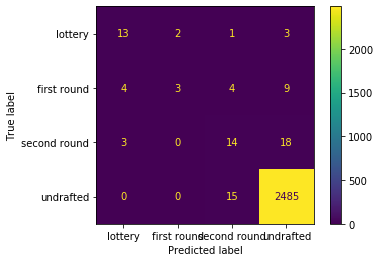

In [33]:
cm = model_evaluation.loc[6, 'confusion matrix']
plot_confusion_matrix(cm, labels)

In the above attempt at building first estimators, the problem of predicting how high in a draft will a given player be drafted (or undrafted) was treated as a typical classification task. Target groups were assumed to be independent from each other, and, perhaps more importantly, unordered. By taking this approach, it was possible to use simple classification models to make predictions, but at the same time the information about the hierarchy of the groups was lost: the fact that lottery players are not only different from second round players (as they belong to two seperate target classes), but are also (arguably) better than them was ignored during training. Let's try to preserve that piece of information by approaching the problem as it was a regression task.

The idea is very simple: because the target variable is represented by integers 1 through 4 with the lower numbers corresponding to better draft positions, it is possible to train regression models on it as it was a continous variable and later convert the predictions made by these models to one of the possible values that the target variable may take. This approach, however, has one fundamental shortcoming: it assumes that consecutive target classes lie at equal distances from each other, which in this problem is hardly the case. Despite that, it is still worth checking if regression models could outperform the classification models that had been defined and trained earlier.

A custom estimator, coherent with the interface of the scikit-learn library, was defined for that purpose. The RegressionClassifier class can take any scikit-learn regression estimator object as a constructor parameter and turn it into a multiclass classifier that predicts a target values that is the closest to the orignal estimator's real number prediction (assuming that possible target values are consecutive integers).

In [48]:
from sklearn.base import ClassifierMixin

class RegressionClassifier(BaseEstimator, ClassifierMixin):
    
    def __init__(self, clf):
        self.clf = clf
    
    def fit(self, X, y):
        self.floor = y.min()
        self.ceil = y.max()
        self.clf.fit(X, y)
    
    def predict(self, X):
        y_pred = np.round(self.clf.predict(X))
        y_pred_cast = []
        for prediction in y_pred:
            prediction = int(prediction)
            if prediction < self.floor:
                y_pred_cast.append(self.floor)
            elif prediction > self.ceil:
                y_pred_cast.append(self.ceil)
            else:
                y_pred_cast.append(prediction)
        return np.array(y_pred_cast)

Just like it was done before with the classifiers, let's now initate and evaluate commmon regression estimators utilizing the RegressionClassifier class that was just defined.

In [49]:
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor

lin_reg = RegressionClassifier(LinearRegression())
svr = RegressionClassifier(SVR())
knr = RegressionClassifier(KNeighborsRegressor())
gbr = RegressionClassifier(GradientBoostingRegressor(random_state=101))
rfr = RegressionClassifier(RandomForestRegressor(random_state=101))
etr = RegressionClassifier(ExtraTreesRegressor(random_state=101))
adar = RegressionClassifier(AdaBoostRegressor(random_state=101))
netr = RegressionClassifier(MLPRegressor(max_iter=1000, random_state=101))

regressors = {'linear regression': lin_reg, 'support vector regressor': svr,
              'k neighbors regressor': knr, 'random forest regressor': rfr,
              'gradient boosting regressor': gbr, 'extra trees regressor': etr,
              'ada boost regressor': adar, 'neural net regreesor': netr,
              }

In [50]:
reg_model_evaluation = quick_compare(regressors, X_train, y_train, X_valid, y_valid)

In [35]:
reg_model_evaluation

,model,train score,valid score,confusion matrix
0,linear regression,0.602848,0.426582,"[[6, 10, 3, 0], [0, 11, 9, 0], [0, 20, 15, 0],..."
1,support vector regressor,0.971505,0.473916,"[[5, 11, 2, 1], [1, 8, 10, 1], [0, 12, 20, 3],..."
2,k neighbors regressor,0.974883,0.427144,"[[8, 3, 7, 1], [2, 6, 12, 0], [5, 6, 21, 3], [..."
3,random forest regressor,0.997526,0.532157,"[[7, 7, 4, 1], [1, 7, 9, 3], [0, 5, 21, 9], [0..."
4,gradient boosting regressor,0.853648,0.545263,"[[8, 7, 4, 0], [0, 10, 9, 1], [0, 9, 22, 4], [..."
5,extra trees regressor,1.000000,0.520528,"[[6, 9, 4, 0], [1, 7, 10, 2], [1, 5, 19, 10], ..."
6,ada boost regressor,0.485741,0.336123,"[[0, 17, 2, 0], [0, 10, 10, 0], [0, 14, 21, 0]..."
7,neural net regreesor,0.992643,0.522652,"[[8, 7, 3, 1], [1, 6, 11, 2], [0, 8, 22, 5], [..."


As it can be seen in the table above, approaching the task as if it was a regression problem yielded results that in most cases are comparable, but usually slightly worse than those observed before. The same kinds of models that performed best when traditional classifiers were used also produced the best scores when regressors were employed for the task, however, the performance of each individual regressor was lower than that of its corresponding classifier. Although it seems like this approach is inferior to the one proposed earlier, it does not necessarily mean than the regression-based estimators will be of no use later in the process. Let's look at the confusion matrix of the gradient boosting regressor to understand why.

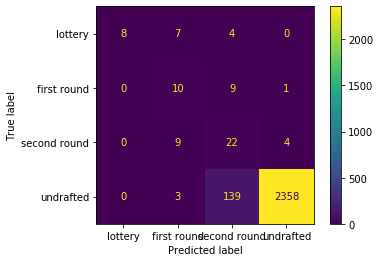

In [39]:
cm = reg_model_evaluation.loc[4, 'confusion matrix']
plot_confusion_matrix(cm, labels)

The confusion matrix reveals an interesting characteristic about this particular estimator (although it holds true for the remaining regressors that did not visibly underperform): it makes different types of errors as compared to the classifiers tested earlier. For example, it mislabeled a lot of instances belonging to the 'undrafted' class and assigned them to the 'second round' category instead (low recall, if the 'undrafted' class was to be treated as a positive class in a binary classification problem), but at the same time it hardly classified any instances from outside that class as 'undrafted' (high precision). Moreover, the highest values in each row of the matrix can be found on its diagonal, meaning that the correct class is predicted more frequently than any of the other three classes. It also did much better than the traditional classifiers labeling 'first round' players. The fact that regressors commit different types of mistakes when making predictions on the validation set might prove useful later in the process.

Instead of treating it as a normal multiclass classification task, or a typical regression problem, let's try yet another possible way to tackle 'ordinal classification' problems like this one. Assuming there are <i>n</i> ordered target classes, let's train <i>n-1</i> binary classifiers, each predicting the probability of <i>y > k</i>, where <i>k</i> is the <i>i-th</i> consecutive target class. In this case, there are 4 ordered classes, so it will be necessary to train 3 binary classifiers (first one treating all instances belonging to class 1 as zeros, second one treating all instances belonging to classes 1 or 2 as zeros, third one treating all instances beloging to classes 1, 2, or 3 as zeros). Subsequently, each of these classifiers will be asked to predict the probability associated with a given instance belonging to the non-zero binary class (i.e. first classifier will predict the probabilty of an instance belonging to an ordinal class higher than 1, second classifier will predict the probability of an instance belonging to an ordinal class higher than 2, and the third classifier will predict the probability of an instance belonging to an ordinal class higher than 3). By subtracting relevant probabilities, it will be then possible to predict which of the ordinal target classes a given instance is the most likely to belong to (e.g. probability of a given instance belonging to class 2 equals the probability of the instance belonging to a class higher than 1 minus the probability of the instance belonging to a class higher than 2). This approach was introduced (and is better explained) in this paper: https://www.cs.waikato.ac.nz/~eibe/pubs/ordinal_tech_report.pdf.

Below is the OrdinalClassifier class defined to makes such predictions. It was developed based on the code proposed here: https://towardsdatascience.com/simple-trick-to-train-an-ordinal-regression-with-any-classifier-6911183d2a3c. It can be used with any classifying estimator coherent with the scikit-learn interface as long as it is equipped with a predict_proba method.

In [51]:
from sklearn.base import clone

class OrdinalClassifier(BaseEstimator, ClassifierMixin):
    
    def __init__(self, clf):
        self.clf = clf
        self.clfs = {}
    
    def fit(self, X, y):
        self.unique_classes = np.sort(np.unique(y))
        if self.unique_classes.shape[0] > 2:
            for unique_class in self.unique_classes[:-1]:
                binary_y = (y > unique_class).astype(np.uint8)
                clf = clone(self.clf)
                clf.fit(X, binary_y)
                self.clfs[unique_class] = clf
        return self
    
    def predict_proba(self, X):
        clfs_predict = {k:self.clfs[k].predict_proba(X) for k in self.clfs}
        predicted = []
        for i, unique_class in enumerate(self.unique_classes):
            if i == 0:
                predicted.append(1 - clfs_predict[unique_class][:,1])
            elif self.unique_classes.shape[0] -1 > i > 0:
                 predicted.append(clfs_predict[unique_class-1][:,1] - clfs_predict[unique_class][:,1])
            else:
                predicted.append(clfs_predict[unique_class-1][:,1])
        return np.vstack(predicted).T
    
    def predict(self, X):
        predictions = []
        predicted_indices = np.argmax(self.predict_proba(X), axis=1)
        for index in predicted_indices:
            predictions.append(self.unique_classes[index])
        return np.array(predictions)

Once again, let's initiate some classifiers capable of predicting probabilities and see how well they can perform compared to the baseline model and models tested before.

In [52]:
log_reg_ord = OrdinalClassifier(LogisticRegression(multi_class='multinomial', solver='saga', max_iter=100000, random_state=101))
rf_ord = OrdinalClassifier(RandomForestClassifier(random_state=101))
knn_ord = OrdinalClassifier(KNeighborsClassifier())
svc_ord = OrdinalClassifier(SVC(probability=True, random_state=101))
gbc_ord = OrdinalClassifier(GradientBoostingClassifier(random_state=101))
et_ord = OrdinalClassifier(ExtraTreesClassifier(random_state=101))
ada_ord = OrdinalClassifier(AdaBoostClassifier(random_state=101))
net_ord = OrdinalClassifier(MLPClassifier(max_iter=1000, random_state=101))

ordinal_classifiers = {'logistic regression': log_reg_ord, 'random forest': rf_ord,
                       'knn': knn_ord, 'svc': svc_ord, 'gradient boosting': gbc_ord,
                       'extra trees': et_ord, 'ada boost': ada_ord, 'neural net': net_ord,
                      }

In [53]:
ord_model_evaluation = quick_compare(ordinal_classifiers, X_train, y_train, X_valid, y_valid)

In [44]:
ord_model_evaluation

,model,train score,valid score,confusion matrix
0,logistic regression,0.856946,0.539512,"[[12, 3, 4, 0], [2, 8, 9, 1], [5, 8, 16, 6], [..."
1,random forest,1.000000,0.551258,"[[11, 4, 1, 3], [1, 4, 6, 9], [4, 1, 13, 17], ..."
2,knn,0.975821,0.419204,"[[8, 2, 8, 1], [2, 7, 11, 0], [5, 6, 20, 4], [..."
3,svc,0.994566,0.557418,"[[13, 2, 2, 2], [6, 5, 6, 3], [4, 5, 15, 11], ..."
4,gradient boosting,0.980332,0.542429,"[[10, 5, 3, 1], [2, 5, 12, 1], [3, 4, 18, 10],..."
5,extra trees,1.000000,0.553180,"[[13, 2, 1, 3], [4, 3, 3, 10], [4, 1, 12, 18],..."
6,ada boost,0.352110,0.386458,"[[15, 0, 0, 4], [5, 0, 0, 15], [10, 0, 0, 25],..."
7,neural net,1.000000,0.523793,"[[10, 5, 2, 2], [2, 3, 8, 7], [3, 4, 16, 12], ..."


It seems like in general the results are again very similar to what they were when classification and regression estimators were used (although they are a little worse when compared to the traditional classifiers), with the exception of the logistic regression model that for the first time produced a competitive score. Below is the confusion matrix of the ordinal classifier based on the extra trees estimator. Again, it looks like it performed well in some areas, and not so great in others. For example, it made very few errors identifying 'lottery' and 'undrafted' players, but confused a significant number of 'second round' instances with 'undrafted' players, and, similarly to traditional classifiers, did poorly differentitating between the 'first round' class and the remaining three classes.

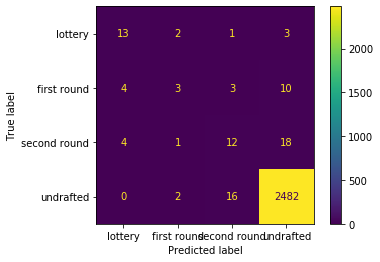

In [51]:
cm = ord_model_evaluation.loc[5, 'confusion matrix']
plot_confusion_matrix(cm, labels)

Three different methods of dealing with the ordinal classification problem were tested and several different models were evaluated in each of them. It is hard to point to a single estimator (or a single method) that clearly outperformed the rest, as the majority of predictors, with few exceptions, achieved a similar f1 score of around 0.50 - 0.55. It was interesting to see that in general it was the same families of models that performed the best and that there were differences in the type of errors commited by the estimators between three different methods. The latter property might soon prove useful, when an ensemble of models is created in an effort to develop a stronger learner outperforming all the individual weak learners (while at the same time reducing variance). In the next steps, an attempt at finding the right set of hyperparameters for each of the models that showed the most promise will be made.

# Step 5: Tuning model hyperparameters

Some of the estimators evaluated in the previous step outperformed the rest by what seems to be a significant margin, however, the differences between various models (except for a few that clearly underperformed, like the k nearest neighbors) are not large enough to select a single estimator (or a family of estimators) that is unambigously better than the rest to continue further analysis with, especially without first tuning the hyperparameters. Because the dataset is relatively small and the training times relatively short (seconds and minutes rather than hours), it will be possible to fine tune several of the models initiated in the previous step (coming from all three methods) and decide later, which of them to include in the final estimator.

Traditionally, cross-validation folds are used during the hyperparameter tuning to compare various combinations of estimator settings and select the one that yields the best results. However, because the training data was oversampled to compensate for the underrepresentation of drafted players, cross-validation might not be a valid method, as the models would be validated on samples that are very similar to those seen during training. Therefore, it is better to use the validation set that was set aside earlier (although it is worth mentioning that tuning the hyperparameters using a predefined set as a reference poses a risk of overfitting to that set). To be able to integrate the validation set in the scikit-learn GridSearchCV class, it will be first necessary to combine training and validation sets and create a predefined split. This is achieved with the function defined below. 

In [54]:
from sklearn.model_selection import PredefinedSplit

def validation_fold(X_train, X_valid, y_train, y_valid):
    X_train_valid = np.vstack([X_train, X_valid])
    y_train_valid = pd.concat([y_train, y_valid])
    y_train_valid.index = range(len(y_train_valid))
    test_fold = [-1 if i < len(y_train) else 0 for i in range(len(y_train_valid))]
    ps = PredefinedSplit(test_fold)
    return X_train_valid, y_train_valid, ps

In [55]:
X_train_valid, y_train_valid, ps = validation_fold(X_train, X_valid, y_train, y_valid)

Because traditional grid search is only capable of tuning one model at a time, let's define a short function that will iterate over multiple models and apply the grid search to each of them to later return a summary of the process in the form of a dataframe.

In [56]:
from sklearn.model_selection import GridSearchCV

def multi_grid_search(X, y, estimators_params, cv=5, scoring='f1_macro'):
    grid_search_fits = {'estimator': [], 'best_params': [], 'best_score': [], 'gs_fit': []}
    for model, hyper_parameter_dict in estimators_params.items():
        gs = GridSearchCV(model, hyper_parameter_dict, cv=cv, n_jobs=-1, scoring=scoring, verbose=4).fit(X, y)
        grid_search_fits['estimator'].append(model)
        grid_search_fits['best_params'].append(gs.best_params_)
        grid_search_fits['best_score'].append(gs.best_score_)
        grid_search_fits['gs_fit'].append(gs)
    return pd.DataFrame(grid_search_fits)

Now it is time to list the estimators to perform the fine-tuning on, and define the dictionaries of hyperparameters to check. All the models that did not visibly underperform will be included in the grid search. This will include traditional classifiers (GradientBoostingClassifier, RandomForesetClassifier, ExtraTreesClassifier, MLPClassifier), regression models that were adapted to perform multiclass classification (GradientBoostingRegressor, RandomForestRegressor), and ordinal classifiers (SupportVectorClassifier, MLPClassifier, GradientBoostingClassifier, LogisticRegression, RandomForestClassifier, ExtraTreesClassifier). In total, 12 of the original 28 models tested before will be evaluated in search for the best set of hyperparameters. Normally, this number would be much smaller, however, as it was mentioned before, because the differences in performance between various estimators were rather low, it is worth checking if tuning the hyperparameters could drastically improve one of the models that did not initially stand out, especially given that the dataset size enables for such a solution in a relatively short time.

Hyperparameters that will be checked in respective models are defined below. The grid search is subsequently initiated and the results presented directly under the code snippet.

In [57]:
gbc_params = {'max_depth': [2, 3, 5, 10],
              'min_samples_split': [2, 5, 10],
              'min_samples_leaf': [1, 2, 5],
             }

rf_params = {'n_estimators': [10, 50, 100, 250],
             'max_depth': [2, 3, 5, 10],
             'min_samples_split': [2, 5, 10],
             'min_samples_leaf': [1, 2, 5],
            }

et_params = {'n_estimators': [10, 50, 100, 250],
             'max_depth': [2, 3, 5, 10],
             'min_samples_split': [2, 5, 10],
             'min_samples_leaf': [1, 2, 5],
            }

net_params = {'hidden_layer_sizes': [(10,), (50,), (100,),
                                     (10, 10), (50, 10), (100, 10),
                                     (100, 50), (100, 50, 10)],
              'learning_rate': ['constant', 'adaptive'],
             }

gbr_params = {'clf__max_depth': [2, 3, 5, 10],
              'clf__min_samples_split': [2, 5, 10],
              'clf__min_samples_leaf': [1, 2, 5],
             }

rfr_params = {'clf__n_estimators': [10, 50, 100, 250],
              'clf__max_depth': [2, 3, 5, 10],
              'clf__min_samples_split': [2, 5, 10],
              'clf__min_samples_leaf': [1, 2, 5],
             }

svc_ord_params = {'clf__C': [0.01, 0.1, 1.0, 10.0],
                  'clf__kernel': ['rbf', 'poly'],
                 }

net_ord_params = {'clf__hidden_layer_sizes': [(10,), (50,), (100,),
                                           (10, 10), (50, 10), (100, 10),
                                           (100, 50), (100, 50, 10)],
               'clf__learning_rate': ['constant', 'adaptive'],
              }

et_ord_params = {'clf__n_estimators': [10, 50, 100, 250],
                 'clf__max_depth': [2, 3, 5, 10],
                 'clf__min_samples_split': [2, 5, 10],
                 'clf__min_samples_leaf': [1, 2, 5],
                }

log_reg_ord_params = {'clf__penalty': ['l1', 'l2'],
                      'clf__C': [0.01, 0.1, 1.0, 10.0],
                     }

classifiers_params = {gbc: gbc_params, rf: rf_params, et: et_params, net: net_params,
                      gbr: gbr_params, rfr: rfr_params,
                      svc_ord: svc_ord_params, net_ord: net_ord_params,
                      gbc_ord: gbr_params, et_ord: et_ord_params,
                      rf_ord: rfr_params, log_reg_ord: log_reg_ord_params
                     }

In [58]:
gs_fits = multi_grid_search(X_train_valid, y_train_valid, classifiers_params, cv=ps)

In [49]:
gs_fits.sort_values('best_score', ascending=False)

,estimator,best_params,best_score,gs_fit
3,"MLPClassifier(max_iter=1000, random_state=101)","{'hidden_layer_sizes': (10, 10), 'learning_rat...",0.599182,GridSearchCV(cv=PredefinedSplit(test_fold=arra...
10,OrdinalClassifier(clf=RandomForestClassifier(r...,"{'clf__max_depth': 10, 'clf__min_samples_leaf'...",0.589122,GridSearchCV(cv=PredefinedSplit(test_fold=arra...
6,"OrdinalClassifier(clf=SVC(probability=True, ra...","{'clf__C': 10.0, 'clf__kernel': 'rbf'}",0.587676,GridSearchCV(cv=PredefinedSplit(test_fold=arra...
8,OrdinalClassifier(clf=GradientBoostingClassifi...,"{'clf__max_depth': 10, 'clf__min_samples_leaf'...",0.587421,GridSearchCV(cv=PredefinedSplit(test_fold=arra...
0,([DecisionTreeRegressor(criterion='friedman_ms...,"{'max_depth': 5, 'min_samples_leaf': 1, 'min_s...",0.580630,GridSearchCV(cv=PredefinedSplit(test_fold=arra...
7,OrdinalClassifier(clf=MLPClassifier(max_iter=1...,"{'clf__hidden_layer_sizes': (100, 50, 10), 'cl...",0.575867,GridSearchCV(cv=PredefinedSplit(test_fold=arra...
9,OrdinalClassifier(clf=ExtraTreesClassifier(ran...,"{'clf__max_depth': 10, 'clf__min_samples_leaf'...",0.571746,GridSearchCV(cv=PredefinedSplit(test_fold=arra...
1,"(DecisionTreeClassifier(max_features='auto', r...","{'max_depth': 10, 'min_samples_leaf': 5, 'min_...",0.568645,GridSearchCV(cv=PredefinedSplit(test_fold=arra...
2,"(ExtraTreeClassifier(random_state=70431583), E...","{'max_depth': 10, 'min_samples_leaf': 1, 'min_...",0.558544,GridSearchCV(cv=PredefinedSplit(test_fold=arra...
4,RegressionClassifier(clf=GradientBoostingRegre...,"{'clf__max_depth': 3, 'clf__min_samples_leaf':...",0.545566,GridSearchCV(cv=PredefinedSplit(test_fold=arra...


As it can be seen above, the fine-tuning resulted in a slightly improved performance with 5 estimators now producing an f1 score of above 0.58 (as compared to 0 before tuning the hyperparameters). Unsurprisingly, traditional and ordinal classifiers were among the best performing models. Regression classifiers did not do so well, with the best of them scoring below 0.55.

Let's try to run an even finer grid search on the estimators that performed the best. In addition to the five best models in terms of the f1 score, the best regression classifier (the one built off a gradient boosting regressor) will also be included in this step.

In [59]:
net_params = {'hidden_layer_sizes': [(10, 10), (25, 25), (25, 10)],
              'learning_rate': ['constant'],
             }

rf_ord_params = {'clf__n_estimators': [25, 40, 50, 60, 75],
                 'clf__max_depth': [7, 10, 15],
                 'clf__min_samples_split': [7, 10, 15],
                 'clf__min_samples_leaf': [1],
                }

svc_ord_params = {'clf__C': [5.0, 10.0, 15.0],
                  'clf__kernel': ['rbf'],
                 }

gbc_ord_params = {'clf__max_depth': [7, 10, 15],
                  'clf__min_samples_split': [7, 10, 12, 15],
                  'clf__min_samples_leaf': [2, 3, 4],
                 }

gbc_params = {'max_depth': [4, 5, 6],
              'min_samples_split': [7, 10, 12, 15],
              'min_samples_leaf': [1],
             }

gbr_params = {'clf__max_depth': [3, 4],
              'clf__min_samples_split': [2, 3, 4],
              'clf__min_samples_leaf': [2, 3, 4],
             }

classifiers_params = {net: net_params,
                      rf_ord: rf_ord_params,
                      svc_ord: svc_ord_params,
                      gbc_ord: gbc_ord_params,
                      gbc: gbc_params,
                      gbr: gbr_params
                     }

In [60]:
gs_fits_finer = multi_grid_search(X_train_valid, y_train_valid, classifiers_params, cv=ps)

In [96]:
gs_fits_finer.sort_values('best_score', ascending=False)

,estimator,best_params,best_score,gs_fit
1,OrdinalClassifier(clf=RandomForestClassifier(r...,"{'clf__max_depth': 15, 'clf__min_samples_leaf'...",0.608469,GridSearchCV(cv=PredefinedSplit(test_fold=arra...
2,"OrdinalClassifier(clf=SVC(probability=True, ra...","{'clf__C': 5.0, 'clf__kernel': 'rbf'}",0.602182,GridSearchCV(cv=PredefinedSplit(test_fold=arra...
0,"MLPClassifier(max_iter=1000, random_state=101)","{'hidden_layer_sizes': (10, 10), 'learning_rat...",0.599182,GridSearchCV(cv=PredefinedSplit(test_fold=arra...
3,OrdinalClassifier(clf=GradientBoostingClassifi...,"{'clf__max_depth': 10, 'clf__min_samples_leaf'...",0.587421,GridSearchCV(cv=PredefinedSplit(test_fold=arra...
4,([DecisionTreeRegressor(criterion='friedman_ms...,"{'max_depth': 5, 'min_samples_leaf': 1, 'min_s...",0.580630,GridSearchCV(cv=PredefinedSplit(test_fold=arra...
5,RegressionClassifier(clf=GradientBoostingRegre...,"{'clf__max_depth': 3, 'clf__min_samples_leaf':...",0.545566,GridSearchCV(cv=PredefinedSplit(test_fold=arra...


It looks like thanks to the extra grid search, it was possible to improve the performance of three of the six shortlisted classifiers. In the next section, these models will be used to build a set of ensemble classifiers, from which the final estimator will be selected.

# Step 6: Building ensembles of classifiers and picking the final estimator

Let's now initate above models with what was found to be the best set of hyperparameters and use them to build a number of voting classifiers, each consisting of a different combination of the base estimators. Hopefully, by averaging out predictions made by multiple estimators, the issues of overfitting and model instability will be addressed. The models are initiated below and the voting classifiers are subsequently built and evaluated using the quick_compare function. 

In [61]:
rf_ord_best = OrdinalClassifier(RandomForestClassifier(max_depth=15, min_samples_leaf=1,
                                                       min_samples_split=10, n_estimators=60,
                                                       random_state=101))
svc_ord_best = OrdinalClassifier(SVC(C=5.0, kernel='rbf', probability=True, random_state=101))
net_best = MLPClassifier(hidden_layer_sizes=(10,10), learning_rate='constant', max_iter=1000, random_state=101)
gbc_ord_best = OrdinalClassifier(GradientBoostingClassifier(max_depth=10, min_samples_leaf=2,
                                                            min_samples_split=10, random_state=101))
gbc_best = GradientBoostingClassifier(max_depth=5, min_samples_leaf=1, min_samples_split=10, random_state=101)
gbr_best = RegressionClassifier(GradientBoostingRegressor(max_depth=3, min_samples_leaf=2,
                                                          min_samples_split=2, random_state=101))

In [62]:
from sklearn.ensemble import VotingClassifier

vc_all = VotingClassifier([('rf_ord_best', rf_ord_best), ('svc_ord_best', svc_ord_best),
                            ('net_best', net_best), ('gbc_ord_best', gbc_ord_best),
                            ('gbc_best', gbc_best), ('gbr_best', gbr_best),
                           ])

vc_top_5 = VotingClassifier([('rf_ord_best', rf_ord_best), ('svc_ord_best', svc_ord_best),
                            ('net_best', net_best), ('gbc_ord_best', gbc_ord_best),
                            ('gbc_best', gbc_best),
                           ])

vc_top_3 = VotingClassifier([('rf_ord_best', rf_ord_best),
                            ('svc_ord_best', svc_ord_best),
                            ('net_best', net_best),
                           ])

vc_varied_3 = VotingClassifier([('rf_ord_best', rf_ord_best),
                                ('net_best', net_best),
                                ('gbr_best', gbr_best),
                               ])

ensemble_classifiers = {'all': vc_all, 'top 5': vc_top_5, 'top 3': vc_top_3, 'varied 3': vc_varied_3}

In [63]:
ensemble_evaluation = quick_compare(ensemble_classifiers, X_train, y_train, X_valid, y_valid)

In [41]:
ensemble_evaluation

,model,train score,valid score,confusion matrix
0,all,0.999038,0.622915,"[[13, 2, 3, 1], [1, 6, 9, 4], [1, 3, 19, 12], ..."
1,top 5,0.999700,0.590997,"[[12, 3, 2, 2], [2, 5, 8, 5], [1, 2, 16, 16], ..."
2,top 3,0.998851,0.633454,"[[14, 1, 2, 2], [0, 6, 8, 6], [2, 3, 16, 14], ..."
3,varied 3,0.996263,0.602417,"[[12, 3, 2, 2], [0, 9, 8, 3], [4, 5, 18, 8], [..."


It appears that the voting classifier built with the top three estimators produces the best results and outperforms all the individual models. Unfortunately, even when multiple models are used to make one prediction (with the models being previously regularized during grid search), the final estimator is still severly overfitting the training set. It seems like this issue is impossible to overcome when dealing with a small dataset like the one that is analyzed here. Luckily, the validation score provides a more reasonable metric of what performance can be expected from the model when exposed to new data (although it is quite likely that the final performance on the yet unseen data will not be as good, given that the hyperparameter fine-tuning was performed using the validation set for reference).

Moreover, as it can be seen in the confusion matrix below, the best voting classifier repeats mistakes of its predecessors confusing first round picks with second round and undrafted players (although not so much with the lottery picks anymore) and mislabeling a significant number of second round picks as belonging to the 'undrafted' class (though, again, it seems like it finds a better balance between precision and recall when it comes to identifying the undrafted players than individual classifiers tested earlier). 

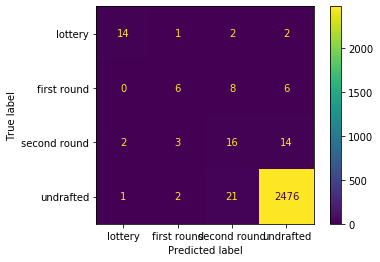

In [44]:
cm = ensemble_evaluation.loc[2, 'confusion matrix']
plot_confusion_matrix(cm, labels)

Having said all that, the voting classifier made of the three of the best performing fine-tuned estimators produces the best results seen so far. It will be now used to construct a full pipeline that transforms the features and makes predictions on the transformed dataset, saved as the final estimator, and applied to the test set. Metrics concerning the performance of the final model on the test are presented in the classification report below.

In [52]:
final_model = vc_top_3
full_pipeline = Pipeline([('feature transformations', feature_transformer),
                          ('final model', final_model),
                         ])
filepath = 'models/final_model.sav'
pickle.dump(final_model, open(filepath, 'wb'))
y_test_pred = full_pipeline.predict(X_test)

In [53]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           1       0.56      0.57      0.57        40
           2       0.25      0.16      0.20        43
           3       0.31      0.34      0.33        76
           4       0.99      0.99      0.99      5357

    accuracy                           0.97      5516
   macro avg       0.53      0.52      0.52      5516
weighted avg       0.97      0.97      0.97      5516



As expected, final model produced a lower f1 score on the test set as compared to the one recorded on the validation set, and the difference was quite significant (0.52 vs 0.63). Perhaps using a seperate set for validation, instead of using cross-validation, led to the model overfitting to the validation set. However, the necessity for oversampling made it impossible to use a different technique, as it was explained before. Below is the confusion matrix of the predictions made by the final estimator on the test set. It is fair to say it did a decent job identifying lottery players (out of 5516 players it successfuly identified 23 of 40 players drafted in lottery) and differentiating between drafted and undrafted players, but it did poorly when trying to distinguish between particular groups of the draft.

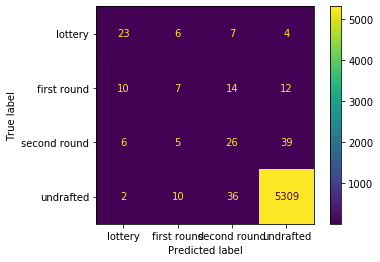

In [55]:
plot_confusion_matrix(confusion_matrix(y_test, y_test_pred), labels)

Altough the final results may not seem very impressive, it is important to look at the bigger picture: determining whether or not will a given player be drafted (and how high in the draft will they be selected) is a very complex problem whose solution depends on many factors beyond those related to the player's (and their team's) performance. First of all, player stats, although it is the only numerical tool available, is not a perfect measure of the players' performance: sometimes it is the intangible characteristics (like the basketball IQ) that make a given player desirable in the eyes of basketball scouts and general managers. Moreover, player's potential and athleticism, traits not reflected in their stats, are often valued by the decision makers way more that their current abilities and skills. Finally, team needs (i.e. what kind of player does a given NBA team need the most at a certain time) are one of the biggest factors influencing draft selections. Given that none of these aspects were taken into account when the models were trained, the process actually yielded a somewhat satisfying solution that sheds some light (although rather dimmed) on where in the draft a given player can expect to be selected.

# Step... back: a whole different approach

Thus far, the models were built with an assumption that all the players are independent from each other and that each of them belongs to one of the four classes that can be predicted by looking at only one player at a time. This approach, although it yielded somewhat promising results, is fundamentally flawed, as it ignores one critical characteristic of the NBA draft: the number of players in each of the groups is limited. Predictive models developed so far were not taught that there can only be 14 players drafted in the lottery every year, 30 players drafted in the first round, and 60 players drafted in total. Moreover, the odds of a particular player being drafted given year depends on how good other players entering the draft that year are: one's performance in a weak draft may be enough for them to grant them one of the 60 spots, while in a strong draft they would go undrafted. Effectively, that means that if two instances are identical in all meaningful features but come from two different seasons, they might belong to two different target classes, making it impossible to construct a classifier that will label all instances correctly. When making predictions, perhaps it would be more fitting not to treat the players collectively, but to compare them within a single season.

A new approach is therefore proposed: all players in the dataset will be categorized as either drafted or undrafted (without dividing them into subclasses). A subset with all the records coming from a selected season will be set aside to act as a test set. The remainder of the dataset will be again split into train and validation sets. Classifiers equipped with a predict_proba method will be then trained on the training set and their performance measured on the validation set. The most promising estimators will be fine tuned and the best classifier (in terms of how well it seperates two classes, measured with an f1 score) will be determined. Subsequently, predictions will be made on the test set and players from that set will be sorted in descending order by the predicted probability of belonging to the 'drafted' class. Then, 14 players with the highest probability of being drafted will be classified as the lottery picks, next 16 players will be classified as the first round picks, and the following 30 players will be classified as the second round picks. Final performance of the model will be then measured using the f1 score.

It has to be noted that this method makes use of the information about the number of players belonging to each of the groups (and how good they are relative to each other) only at the time of making predictions, but it still ignores it during training and validation: in those stages, all the players are treated as belonging to one cohort regardless of the season the data is coming from. 

There is one more limitation to that approach: not all the players entering the draft (and being selected in the draft) played in the NCAA. For example, as it is demostrated in a cell below, in the 2021 NBA draft, only 50 of the 60 players selected in the draft had previous college experience (the remaining 10 were either international or played in the NBA Development League). To accurately assess the models' performance, it will be therefore more fitting to use the first <i>n</i> players with the highest predicted probability as those belonging to a given class with <i>n</i> being a number of college players present in the dataset that actually belong to that class. In a real life scenario, if the model is to be used to predict the order of selection in a future draft, this will not be possible (as the number of players without prior college experience being selected in the draft will be unknown), however, the model constructed that way can still be useful to rank college players enrolled for the draft.

In [67]:
class_2021 = dataset[dataset['season']==2021]
len(class_2021[(class_2021['draft']!=4)])

50

At this point it has to be noted that because a different subset of data will be set aside to serve as a test set, there is going to be some data leakage. It is impossible to avoid now that a whole different approach had already been implemented and tested, and some of the data that have been previously used for testing will now be used for training and validation. However, the leakage should not have a major impact on the outcomes of the process, as different methods will be employed and the information from outside the new training set will not be directly used. 

Let's now refer back to the original dataset.

In [68]:
dataset.head()

,name,school,season,school_year,position,height,weight,games_played,games_started,games_won,...,team_eff_fg_pct,srs_off,srs_def,sos,team_ppg,opp_ppg,off_rating,def_rating,ap_poll_rank,draft
0,Michael Lyons,Air Force,2013,senior,G,196.0,88.0,30,30,17,...,0.551,4.05,0.01,4.16,70.0,67.8,110.09,102.85,NaN,4
1,Tom Fow,Air Force,2011,senior,F,198.0,93.0,32,32,16,...,0.540,-1.94,4.65,3.31,64.8,65.1,106.44,101.45,NaN,4
2,Derek Brooks,Air Force,2011,senior,F,196.0,91.0,32,1,16,...,0.540,-1.94,4.65,3.31,64.8,65.1,106.44,101.45,NaN,4
3,Evan Washington,Air Force,2011,senior,G,193.0,91.0,32,32,16,...,0.540,-1.94,4.65,3.31,64.8,65.1,106.44,101.45,NaN,4
4,Taylor Broekhuis,Air Force,2013,senior,C,201.0,88.0,32,32,18,...,0.551,4.05,0.01,4.16,70.0,67.8,110.09,102.85,NaN,4


First, let's transform the target variable to only differentiate between drafted (1) and undrafted (0) players.

In [69]:
y_binary = y.apply(lambda x: int(x < 4))

Let's now set aside the test set. Data coming from the 2019/2020 and 2020/2021 seasons will be used for that purpose. A corresponding column of untransformed target variables will also be put aside, as not to lose the information about specific classes of each instance in the test set. This column will be later used to evaluate the final performance of the model.

In [70]:
X_rest = X[[s not in (2020, 2021) for s in X['season']]]
y_binary_rest = y_binary[X_rest.index]
y_rest = y[X_rest.index]

X_test = X[(X['season']==2020) | (X['season']==2021)]
y_binary_test = y_binary[X_test.index]
y_test = y[X_test.index]

It is time to split the rest of the dataset (i.e. records that do not come from the 2019/2020 or the 2020/2021 season) between train and validation sets.

In [71]:
X_train, X_valid, y_binary_train, y_binary_valid = train_test_split(X_rest,
                                                                    y_binary_rest,
                                                                    stratify=y_rest,
                                                                    test_size=0.2,
                                                                    random_state=RS)

Train and validation sets should now be transformed with a previously defined transformer pipeline (that is first refitted to the new training set). Training set will be also resampled so that both classes are represented in equal cardinality.

In [72]:
X_train = feature_transformer.fit_transform(X_train)
X_valid = feature_transformer.transform(X_valid)
X_train, y_binary_train = SMOTE(random_state=RS).fit_resample(X_train, y_binary_train)

Again, let's create a baseline model (that makes random predictions with probability of each class proportional to the prevalence of that class in the validation set) and measure its performance. It yields an f1 score of around 0.06.

In [73]:
rng = np.random.default_rng()
y_pred_baseline = [1] * len(y_binary_valid)
f1_score(y_binary_valid, y_pred_baseline)

0.05559105431309904

Let's now initiate some basic estimators that are equipped with the predict_proba method and check how they perform. Once again, the f1 score will be used to evaluate the models, however, this time a 'binary' averaging method will be used, since the classifiers are dealing with a binary problem.

In [74]:
log_reg_bin = LogisticRegression(max_iter=100000, solver='liblinear', random_state=RS)
dt_bin = DecisionTreeClassifier(random_state=RS)
rf_bin = RandomForestClassifier(random_state=RS)
knn_bin = KNeighborsClassifier()
svc_bin = SVC(max_iter=100000, probability=True, random_state=RS)
gbc_bin = GradientBoostingClassifier(random_state=RS)
et_bin = ExtraTreesClassifier(random_state=RS)
ada_bin = AdaBoostClassifier(random_state=RS)
net_bin = MLPClassifier(activation='logistic', max_iter=10000, random_state=RS)

binary_classifiers = {'logistic regression': log_reg_bin,
                      'decision tree': dt_bin,
                      'random forest': rf_bin,
                      'knn': knn_bin,
                      'svc': svc_bin,
                      'gradient boosting': gbc_bin,
                      'extra trees': et_bin,
                      'ada boost': ada_bin,
                      'neural net': net_bin,
                      }

In [75]:
bin_model_evaluation = quick_compare(binary_classifiers, X_train, y_binary_train,
                                     X_valid, y_binary_valid, average='binary')

In [49]:
bin_model_evaluation

,model,train score,valid score,confusion matrix
0,logistic regression,0.978345,0.604982,"[[2847, 109], [2, 85]]"
1,decision tree,1.000000,0.581281,"[[2899, 57], [28, 59]]"
2,random forest,1.000000,0.666667,"[[2925, 31], [28, 59]]"
3,knn,0.974329,0.440111,"[[2763, 193], [8, 79]]"
4,svc,0.988959,0.669388,"[[2880, 76], [5, 82]]"
5,gradient boosting,0.992052,0.696035,"[[2895, 61], [8, 79]]"
6,extra trees,1.000000,0.706522,"[[2924, 32], [22, 65]]"
7,ada boost,0.985818,0.652361,"[[2886, 70], [11, 76]]"
8,neural net,0.999958,0.707182,"[[2926, 30], [23, 64]]"


Again, all the estimators outperformed the baseline model, and again the bar was not set very high. The multi-layer perceptron classifier (neural net) produced the best f1 score on the validation set, and below is the confusion matrix of the predictions it made. It labeled the majority of instances correctly with a slightly better recall than precision. Keeping in mind that perfect seperation might not even be possible (for reasons mentioned earlier), this model actually did a solid job. It will be further refined, along with other models that yielded promising results, using grid search.

In [104]:
binary_labels = ['undrafted', 'drafted']

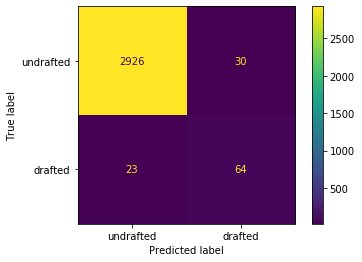

In [50]:
cm = bin_model_evaluation.loc[8, 'confusion matrix']
plot_confusion_matrix(cm, binary_labels)

A predefined split is created (so that different sets of hyperparameters can be evaluated on the validation set), hyperparameter grids are defined, and the grid search is initiated. The results can be found below.

In [87]:
X_train_valid, y_binary_train_valid, ps = validation_fold(X_train, X_valid, y_binary_train, y_binary_valid)

In [77]:
log_reg_params = {'penalty': ['l1', 'l2'],
                  'C': [0.01, 0.1, 1., 10.],
                 }

rf_params = {'n_estimators': [10, 50, 100, 250],
             'max_depth': [2, 3, 10, 15],
             'min_samples_split': [2, 5, 10],
             'min_samples_leaf': [1, 2, 5],
            }
svc_params = {'C': [0.01, 0.1, 1.0, 10.0],
              'kernel': ['rbf', 'poly']
             }
gbc_params = {'max_depth': [2, 3, 5, 10],
              'min_samples_split': [2, 5, 10],
              'min_samples_leaf': [1, 2, 5],
             }
et_params = {'n_estimators': [10, 50, 100, 250],
             'max_depth': [2, 3, 10, 15],
             'min_samples_split': [2, 5, 10],
             'min_samples_leaf': [1, 2, 5],
            }

ada_params = {'base_estimator': [DecisionTreeClassifier()],
              'base_estimator__max_depth': [1, 2, 5, 10],
              'base_estimator__min_samples_split': [2, 5, 10],
              'base_estimator__min_samples_leaf': [1, 2, 5],
              'n_estimators': [10, 50, 100, 250],
             }

net_params = {'hidden_layer_sizes': [(10,), (100,), (100, 10), (100, 100), (100, 100, 10), (100, 100, 100)],
              'learning_rate_init': [0.001, 0.01, 0.1],
              'learning_rate': ['constant', 'adaptive'],
             }

models_params = {rf_bin: rf_params,
                 svc_bin: svc_params,
                 gbc_bin: gbc_params,
                 et_bin: et_params,
                 net_bin: net_params,
                 ada_bin: ada_params,
                }

In [78]:
gs_fits = multi_grid_search(X_train_valid, y_binary_train_valid, models_params, cv=ps, scoring='f1')

In [231]:
gs_fits.sort_values('best_score', ascending=False)

,estimator,best_params,best_score,gs_fit
2,GradientBoostingClassifier(random_state=101),"{'max_depth': 5, 'min_samples_leaf': 2, 'min_s...",0.751269,GridSearchCV(cv=PredefinedSplit(test_fold=arra...
5,AdaBoostClassifier(random_state=101),{'base_estimator': DecisionTreeClassifier(max_...,0.723164,GridSearchCV(cv=PredefinedSplit(test_fold=arra...
4,"MLPClassifier(activation='logistic', max_iter=...","{'hidden_layer_sizes': (100,), 'learning_rate'...",0.707182,GridSearchCV(cv=PredefinedSplit(test_fold=arra...
0,RandomForestClassifier(random_state=101),"{'max_depth': 15, 'min_samples_leaf': 1, 'min_...",0.699507,GridSearchCV(cv=PredefinedSplit(test_fold=arra...
1,"SVC(max_iter=100000, probability=True, random_...","{'C': 10.0, 'kernel': 'rbf'}",0.674033,GridSearchCV(cv=PredefinedSplit(test_fold=arra...
3,ExtraTreesClassifier(random_state=101),"{'max_depth': 15, 'min_samples_leaf': 1, 'min_...",0.641026,GridSearchCV(cv=PredefinedSplit(test_fold=arra...


As it is shown in the dataframe above, three classifiers managed to beat the 0.7 mark (when it comes to the f1 score on the validation set), with the gradient boosting classifier scoring above the 0.75 mark. Let's see if it is possible to further improve the top five estimators with a finer grid search.

In [79]:
gbc_params = {'max_depth': [4, 5, 6, 7],
              'min_samples_split': [2, 3, 4],
              'min_samples_leaf': [2, 3, 4],
             }

ada_params = {'base_estimator': [DecisionTreeClassifier()],
              'base_estimator__max_depth': [8, 10, 12],
              'base_estimator__min_samples_split': [2, 3, 4],
              'base_estimator__min_samples_leaf': [2, 3, 4],
              'n_estimators': [75, 100, 125],
             }

net_params = {'hidden_layer_sizes': [(100,), (100, 50), (100, 50, 10)],
              'learning_rate': ['constant'],
              'learning_rate_init': [0.001],
             }

svc_params = {'C': [5.0, 8.0, 10.0, 12.0, 15.0],
              'kernel': ['rbf']
             }

rf_params = {'n_estimators': [25, 40, 50, 60, 75],
             'max_depth': [12, 15, 20],
             'min_samples_split': [3, 4, 5, 6, 7],
             'min_samples_leaf': [1],
            }

et_params = {'n_estimators': [75, 100, 125, 150],
             'max_depth': [12, 15, 20],
             'min_samples_split': [8, 10, 12, 15],
             'min_samples_leaf': [1],
            }

models_params = {gbc_bin: gbc_params,
                 ada_bin: ada_params,
                 net_bin: net_params,
                 svc_bin: svc_params,
                 rf_bin: rf_params,
                 et_bin: et_params,
                }

In [80]:
gs_fits_finer = multi_grid_search(X_train_valid, y_binary_train_valid, models_params, cv=ps, scoring='f1')

In [250]:
gs_fits_finer.sort_values('best_score', ascending=False)

,estimator,best_params,best_score,gs_fit
2,GradientBoostingClassifier(random_state=101),"{'max_depth': 5, 'min_samples_leaf': 2, 'min_s...",0.751269,GridSearchCV(cv=PredefinedSplit(test_fold=arra...
4,AdaBoostClassifier(random_state=101),{'base_estimator': DecisionTreeClassifier(max_...,0.736264,GridSearchCV(cv=PredefinedSplit(test_fold=arra...
0,RandomForestClassifier(random_state=101),"{'max_depth': 20, 'min_samples_leaf': 1, 'min_...",0.721649,GridSearchCV(cv=PredefinedSplit(test_fold=arra...
3,"MLPClassifier(activation='logistic', max_iter=...","{'hidden_layer_sizes': (100,), 'learning_rate'...",0.707182,GridSearchCV(cv=PredefinedSplit(test_fold=arra...
1,"SVC(max_iter=100000, probability=True, random_...","{'C': 12.0, 'kernel': 'rbf'}",0.685714,GridSearchCV(cv=PredefinedSplit(test_fold=arra...
5,ExtraTreesClassifier(random_state=101),"{'max_depth': 20, 'min_samples_leaf': 1, 'min_...",0.673267,GridSearchCV(cv=PredefinedSplit(test_fold=arra...


Further refinements did not bring any major improvements and the score of the best estimator (the gradient boosting classifer) did not improve at all. Nevertheless, these six predictors will now be initiated with the most effective set of hyperparameters to be then used to build a number of voting classifiers. This time, soft voting will be used so that the final estimator can be later used to predict the probability of a given player belonging to the 'drafted' class.

In [81]:
gbc_bin_best = GradientBoostingClassifier(max_depth=5, min_samples_leaf=2, min_samples_split=2, random_state=RS)
ada_bin_best = AdaBoostClassifier(DecisionTreeClassifier(max_depth=10, min_samples_leaf=2, min_samples_split=2),
                                  n_estimators=75, random_state=RS)
net_bin_best = MLPClassifier(hidden_layer_sizes=(100,), learning_rate='constant', learning_rate_init=0.001,
                             activation='logistic', max_iter=10000, random_state=RS)
svc_bin_best = SVC(C=12.0, kernel='rbf', max_iter=100000, probability=True, random_state=RS)
rf_bin_best = RandomForestClassifier(max_depth=20, min_samples_leaf=1, min_samples_split=5, n_estimators=75, random_state=RS)
et_bin_best = ExtraTreesClassifier(max_depth=20, min_samples_leaf=1, min_samples_split=8, n_estimators=100, random_state=RS)

In [82]:
vc_all = VotingClassifier([('gbc_bin_best', gbc_bin_best), ('ada_bin_best', ada_bin_best),
                           ('net_bin_best', net_bin_best), ('svc_bin_best',svc_bin_best),
                           ('rf_bin_best', rf_bin_best), ('et_bin_best', et_bin_best),
                          ], voting='soft')

vc_top_5 = VotingClassifier([('gbc_bin_best', gbc_bin_best), ('ada_bin_best', ada_bin_best),
                            ('net_bin_best', net_bin_best), ('svc_bin_best',svc_bin_best),
                            ('rf_bin_best', rf_bin_best),
                            ], voting='soft')

vc_top_3 = VotingClassifier([('gbc_bin_best', gbc_bin_best),
                             ('ada_bin_best', ada_bin_best),
                             ('net_bin_best', net_bin_best),
                            ], voting='soft')

vc_varied_3 = VotingClassifier([('gbc_bin_best', gbc_bin_best),
                                ('net_bin_best', net_bin_best),
                                ('svc_bin_best',svc_bin_best),
                                ], voting='soft')

ensemble_binary_classifiers = {'all': vc_all, 'top 5': vc_top_5,
                               'top 3': vc_top_3, 'varied 3': vc_varied_3}

In [84]:
ensemble_binary_evaluation = quick_compare(ensemble_binary_classifiers, X_train, y_binary_train,
                                           X_valid, y_binary_valid, average='binary')

Below is the comparison between four different voting classifiers that were created and the classification matrix of predictions made by the one that performed best (in terms of the f1 score). 

In [260]:
ensemble_binary_evaluation

,model,train score,valid score,confusion matrix
0,all,1.000000,0.731429,"[[2932, 24], [23, 64]]"
1,top 5,1.000000,0.731429,"[[2932, 24], [23, 64]]"
2,top 3,1.000000,0.747253,"[[2929, 27], [19, 68]]"
3,varied 3,0.999831,0.711656,"[[2938, 18], [29, 58]]"


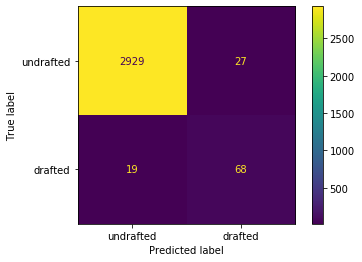

In [263]:
cm = ensemble_binary_evaluation.loc[2, 'confusion matrix']
plot_confusion_matrix(cm, binary_labels)

The voting classifier consisting of the top 3 individual estimators (gradient boosting classifier, adaptive boosting classifier, and multi-layer perceptron classifier) will be selected as the final model of this approach. As it can be seen in the confusion matrix above, it performs quite well seperating drafted players from undrafted players. It made relatively few false negative predictions, meaning that if a given instance is labeled as 'undrafted' there is a very good chance it truly belongs to that class. However, its precision leaves a lot to be desired: if a player is classified as 'drafted', there is still going to be a lot of uncertainy whether it is their true class.

It has to be kept in mind that the ultimate goal was not to predict whether or not a given player is going to be drafted, but to estimate the specific group they are going to be selected (or not selected) in instead. The final model was chosen with an assumption that the estimator that can best seperate drafted and undrafted players from each other, will also perform best when it is asked to predict probabilities of the players belonging to the postitive class. It is a reasonable assumption, although it does not necessarily need to be true. However, choosing a different approach, and validating the models using all four target classes instead of just the two, would be far more problematic while at the same time being very likely to yield little to no improvement in performance. Therefore, the final estimator was selected solely on the basis of how well was it able to differentiate between drafted and undrafted players. A new pipeline, made of the feature transformer and the final binary model, is defined and exported below.

In [89]:
final_binary_model = vc_top_3
full_binary_pipeline = Pipeline([('feature transformations', feature_transformer),
                                 ('final model', final_binary_model),
                                ])
filepath = 'models/final_binary_model.sav'
pickle.dump(full_binary_pipeline, open(filepath, 'wb'))

It is time to apply the final pipeline to the test set and see how it performs. Both binary and multiclass predictions will be made on the test set. The latter will be made on one part of the test set at a time, each containing data coming from a single season. For that reason, the test set needs to be first split into two parts.

In [90]:
X_test_2020 = X_test[X_test['season']==2020]
X_test_2021 = X_test[X_test['season']==2021]
y_binary_test_2020 = y_binary_test[X_test_2020.index]
y_binary_test_2021 = y_binary_test[X_test_2021.index]
y_test_2020 = y_test[X_test_2020.index]
y_test_2021 = y_test[X_test_2021.index]

In [94]:
y_binary_pred = full_binary_pipeline.predict(X_test)
y_pred_proba_2020 = full_binary_pipeline.predict_proba(X_test_2020)
y_pred_proba_2021 = full_binary_pipeline.predict_proba(X_test_2021)

First, let's check how the final model performs on the test set when it only makes binary predictions (i.e. tries to label players as either 'drafted' or 'undrafted') and the information about the number of players actually belonging to a given class is omitted. As it can be seen below, the estimator does a relatively good job, producing an f1 score comparable to the one seen earlier on the validation set (0.71 vs 0.75). It means that this time the final model is not overfitted to the validation set as much as it was previously (when a different approach was employed). 

The model is far from perfect and still makes a lot of type I and type II errors. However, it seems like this time extra precision was traded for some of the recall (there are more false negatives than false positives, as opposed to what can be seen in the predictions made on the validation set), meaning that if a given player is assigned to a positive class, there is a better chance of them actually belonging to that class.

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3076
           1       0.74      0.67      0.71        98

    accuracy                           0.98      3174
   macro avg       0.87      0.83      0.85      3174
weighted avg       0.98      0.98      0.98      3174



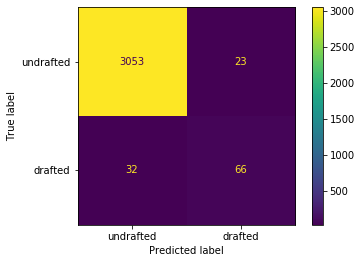

In [332]:
print(classification_report(y_binary_test, y_binary_pred))
plot_confusion_matrix(confusion_matrix(y_binary_test, y_binary_pred), binary_labels)

Let's now look at the test set one season at a time and include the information about how many players from the NCAA were actually drafted that year. First, it will be necessary to define a function that will convert the probability of a given instance belonging to the positive class into one of possible classes based on the number of instances that truly belong to these classes. For example, if there were 50 players from the NCAA drafted in 2021, it will assign 50 players with the highest predicted probability to the 'drafted' class (it can also be used in conjunction with more classes, like 'lottery', 'first round', and 'second round').

In [95]:
def convert_predictions(y_pred_proba, y_true):
    y_pred_proba = y_pred_proba[:, 1]
    y_pred_proba = pd.Series(y_pred_proba)
    y_pred_proba.index = y_true.index
    y_pred_proba = y_pred_proba.sort_values()
    targets_list = []
    for key, value in dict(y_true.value_counts()).items():
        for _ in range(value):
            targets_list.append(key)
    predictions = pd.Series(targets_list)
    predictions.index = y_pred_proba.index
    predictions = predictions.reindex(index=y_true.index)
    return predictions

Predictions were made separately on the two parts of the dataset that contained data coming from a single season each, and were subsequently concatenated so that the aggregate results can be compared to those produced earlier (when the information about the number of players in each of the groups was not considered). It turns out, the additional information contributed to a slightly better performance, although only by a very tight margin: it successfuly identified 71 out of 98 players drafted over two years (as compared to 66 before) and yielded an f1 score of 0.72.  

In [96]:
y_binary_pred_2020 = convert_predictions(y_pred_proba_2020, y_binary_test_2020)
y_binary_pred_2021 = convert_predictions(y_pred_proba_2021, y_binary_test_2021)
y_binary_pred_order = pd.concat([y_binary_pred_2020, y_binary_pred_2021])
y_binary_test_order = pd.concat([y_binary_test_2020, y_binary_test_2021])

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3076
           1       0.72      0.72      0.72        98

    accuracy                           0.98      3174
   macro avg       0.86      0.86      0.86      3174
weighted avg       0.98      0.98      0.98      3174



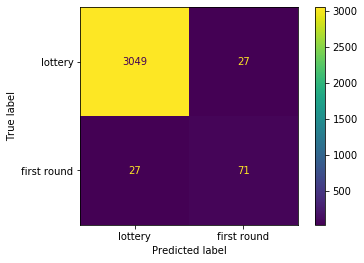

In [336]:
print(classification_report(y_binary_test_order, y_binary_pred_order))
plot_confusion_matrix(confusion_matrix(y_binary_test_order, y_binary_pred_order), binary_labels)

Finally, let's find out how the model performs when it is asked to predict which of the four possible classes ('lottery', 'first round', 'second round', 'undrafted') a given player belongs to. Once again, it will be necessary to convert the probabilities predicted by the final estimator into one of the target groups.

In [100]:
y_multi_pred_2020 = convert_predictions(y_pred_proba_2020, y_test_2020)
y_multi_pred_2021 = convert_predictions(y_pred_proba_2021, y_test_2021)
y_multi_pred_order = pd.concat([y_multi_pred_2020, y_multi_pred_2021])
y_multi_test_order = pd.concat([y_test_2020, y_test_2021])

              precision    recall  f1-score   support

           1       0.41      0.41      0.41        22
           2       0.26      0.26      0.26        27
           3       0.37      0.37      0.37        49
           4       0.99      0.99      0.99      3076

    accuracy                           0.97      3174
   macro avg       0.51      0.51      0.51      3174
weighted avg       0.97      0.97      0.97      3174



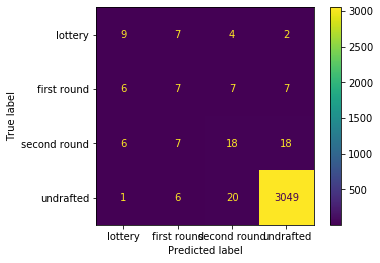

In [340]:
print(classification_report(y_multi_test_order, y_multi_pred_order))
plot_confusion_matrix(confusion_matrix(y_multi_test_order, y_multi_pred_order), labels)

Although the results achieved now should not be directly compared to those produced earlier when the problem was approached in a different way (as different subsets of data were used for training, validation, and testing), it cannot go unnoticed how similar the final f1 scores are (0.51 now vs 0.52 before). Looking only at that score, it seems like including the additional information when making predictions does not result in major improvements in performance (if any). However, inspecting the confusion matrix, it appears that the final estimator built using this approach makes predictions that are more sensible: it still misclassifies a significant number of instances, but it now predicts the correct class more often (or just as often) than any of the other three classes individually (note the values on the diagonal). Moreover, when it does make errors, it usually mistakes a given class for the class that is adjacent to it: the further away two classes are from each other, the less likely they are to be mistaken for each other. Consequently, when a given player is labeled as a lottery pick, they cannot be sure they actually belong to that class, however, they have a high chance of being drafted at the very least. At the other end of the spectrum, instances classifed as 'undrafted' have low odds of actually ending up drafted, and can be almost certain that if they do get drafted, the are not going to make it into the first round.

Moreover, what is advantageous about this approach, is the impretability of the results. Even though the final estimator is not extremely effective seperating the dataset with regards to the target variable, the probaiblity it predicts can still be very useful and informative. It can be interpreted as the probability of a particular player getting drafted assuming that college performance (expressed in both basic and more advanced player and team stats) is the only meaningful thing affecting the decision-making process of the NBA franchises' general managers. It is a huge simplification that cannot be overlooked. Therefore, whatever the predictions of the estimator developed over the course of this project are, they should not be treated literally, but they can potentially serve as one of the inputs the NBA teams' decision makers use when considering their options before the draft.

Having said that, below is an example 2021 NBA mock draft based off of the probabilities predicted with the final estimator. Players enrolled for the draft were sorted by the probability of being drafted in descending order, and the first 60 players were displayed along with the actual pick they were drafted (or undrafted) with. No players from outside the NCAA are included in this mock draft. For that and other reasons explained earlier, it should not be treated literally, but rather as a comparison of what the draft would look like if the NCAA performance was all that mattered versus how it actually looked like. Interestingly enough, many of the players that were predicted to be drafted by the model but in reality went undrafted, ended up playing in the NBA. Such players are indicated with brackets.

In [102]:
mock_draft = pd.DataFrame(np.c_[dataset[dataset['season']==2021]['name'], y_pred_proba_2021[:, -1]],
                          columns=['player', 'probability'], index=dataset[dataset['season']==2021].index)
mock_draft = pd.merge(mock_draft, draft_2021,
                      left_index=True, right_index=True).sort_values('probability', ascending=False).head(60)
mock_draft.drop('name', axis=1, inplace=True)
mock_draft.index = range(1, 61)

In [434]:
mock_draft

,player,probability,draft
1,Moses Moody,0.99898,14
2,Jalen Suggs,0.997242,5
3,Evan Mobley,0.995794,3
4,JT Thor,0.99181,37
5,Chris Duarte,0.975356,13
6,Cade Cunningham,0.97432,1
7,Jared Butler,0.947045,40
8,Scottie Barnes,0.931504,4
9,Franz Wagner,0.930907,8
10,Justin Champagnie,0.929582,undrafted (NBA)


# Closing thoughts

The main objective of the project was to predict which of the four possible draft groups a given player belongs to based solely on their college performance (expressed with easily available player and team stats). Along the way, various machine learning techniques were employed to solve the problem, and many different approaches were proposed and evaluated. In the end, the best model achieved an f1 score of 0.51 (averaged over all possible classes using an unweighted, or macro, method) when it tried to split the pool of players into four groups (lottery, first round, second round, and undrafted), and of 0.72 when it only attempted to classify them as either drafted or undrafted.

The results may not seem very impressive, however, it has to be once again mentioned that the factors affecting draft selections go far beyond players' college performance (and even farther beyond college stats). Estimators that neglect all other influences were doomed to fail, if success was to be defined as a perfect seperation between all groups of players. With that in mind, it is not a stretch to say that the project actually yielded results that are satisfactory at the very least, even though it did not achieve seperation anywhere close to perfection.

Between the two main approaches presented in the notebook, it is clear that the second one (predicting probabilities of players getting drafted given year) is superior to the first one (that treated all the players collectively), despite the fact it produced a slightly worse f1 score (note it was tested on different subsets of data). Its strength lays in its interpretability: although the predictions of the final model built that way cannot be treated literally, they can be very well used by the NBA general managers as one of the inputs to their decision-making process. The probabilities estimated by the final model could help them rank the players with regards to how well they performed in their final season in the NCAA and assess their chances of being drafted if all other factors were meaningless.

There are certainly some areas of the project that could be improved for a slightly better performance of the models. For example, it would probably be very beneficial for the accuracy of predictions if the information about the number of players belonging to each of the target classes particular year was included during training, and not only when making predictions. Possibly, some other transformations could be applied to the dataset making it easier to seperate with respect to the target variable. Finally, more advanced machine learning techniques could probably be employed to solve the problem with better success. However, it is doubtful that any of these things would drastically improve the predictions made by the final model: it seems like the most troublesome limitation of this project is not possible to overcome with some simple trick and lays in the data itself. The size of the dataset is simply too small for the estimators to be properly trained, especially with how imbalanced with regards to the target variable it was. Oversampling underrepresented classes helped restrict the effects of that imbalance, while at the same time increasing the number of instances to train models on, but it did not introduce any new information to the training set. Significant improvements could only be achieved if significantly more data was to be collected. This, however, is impossible as the number of NCAA Division I players enrolled for the draft in the last decade is very limited.

Finally, at the end of the day, draft selections are made by humans, and humans make errors. Being drafted or undrafted is not the players' inherent characteristic: they only belong to one of the groups because another human made such a decision. If the aim of the project was to predict how well would a given player perform in the NBA based on their college stats, then draft selection is not the best target variable that the models could be trained on, as it only represents expectations towards the players' career, and not their actual career. In such a scenario, some different quantity, one that encapsulates various metrics corresponsing to the player's success (e.g. points per game, PER, All-Star Game selections, championships, etc.), should be used as a target variable instead. Perhaps such a challenge could be tackled in a seperate project, and the outcomes could serve as guidance for the decision-makers before the draft.

Having said all that, the final estimator that was developed over the course of the project produced interesting results and although college stats clearly do not carry enough information to distinguish between players belonging to particular draft groups with high precision and recall, the solution built throughout the project may still prove valuable for the NBA franchises' scouts and general managers.